In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.datasets as Datasets
import torchvision.transforms as transforms
import torch.nn.functional as F
import torchvision.models as models
import torchvision.utils as vutils
from torch.distributions import Categorical
from torchvision.utils import make_grid
from torch.optim import Adam

from transformers import DistilBertModel, DistilBertTokenizer, CLIPTokenizer, CLIPTextModel

import random
import math
import numpy as np
import matplotlib.pyplot as plt
from collections import namedtuple
import glob
import pickle
import inspect
import os
from IPython.display import clear_output
from PIL import Image
from tqdm.notebook import trange, tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [2]:
model_dir = os.path.dirname(os.path.abspath(os.path.join("weights", f"v0.1", f"vgg.pth")))
os.makedirs(model_dir, exist_ok=True)

In [3]:
data_dir = "data"
os.makedirs(data_dir, exist_ok=True)

In [4]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [5]:
!mkdir -p data
!cp "/content/drive/MyDrive/Machine Learning/advanced-deep-learning/diffusion/Latent Diffusion/Conditioned/CelebA/CelebAMask-HQ.zip" data/

In [6]:
!unzip data/CelebAMask-HQ.zip -d data/

Streaming output truncated to the last 5000 lines.
  inflating: data/CelebAMask-HQ/CelebAMask-HQ-mask-anno/14/28634_l_lip.png  
  inflating: data/__MACOSX/CelebAMask-HQ/CelebAMask-HQ-mask-anno/14/._28634_l_lip.png  
  inflating: data/CelebAMask-HQ/CelebAMask-HQ-mask-anno/14/29702_r_eye.png  
  inflating: data/__MACOSX/CelebAMask-HQ/CelebAMask-HQ-mask-anno/14/._29702_r_eye.png  
  inflating: data/CelebAMask-HQ/CelebAMask-HQ-mask-anno/14/29225_hair.png  
  inflating: data/__MACOSX/CelebAMask-HQ/CelebAMask-HQ-mask-anno/14/._29225_hair.png  
  inflating: data/CelebAMask-HQ/CelebAMask-HQ-mask-anno/14/28267_r_ear.png  
  inflating: data/__MACOSX/CelebAMask-HQ/CelebAMask-HQ-mask-anno/14/._28267_r_ear.png  
  inflating: data/CelebAMask-HQ/CelebAMask-HQ-mask-anno/14/28829_skin.png  
  inflating: data/__MACOSX/CelebAMask-HQ/CelebAMask-HQ-mask-anno/14/._28829_skin.png  
  inflating: data/CelebAMask-HQ/CelebAMask-HQ-mask-anno/14/28351_l_brow.png  
  inflating: data/__MACOSX/CelebAMask-HQ/CelebAMas

In [41]:
dataset_params = {
    "image_path": "data/CelebAMask-HQ",
    "image_channels": 3,
    "image_size": 256,
    "name": "celebhq"
}

diffusion_params = {
    "num_timesteps": 1000,
    "beta_start": 0.00085,
    "beta_end": 0.012,
}

ldm_params = {
    "down_channels": [256, 384, 512, 768],
    "mid_channels": [768, 512],
    "down_sample": [True, True, True],
    "attn_down": [True, True, True], # Attention in the DownBlock and UpBlock of VQ-VAE
    "time_emb_dim": 512,
    "norm_channels": 32,
    "num_heads": 16,
    "conv_out_channels": 128,
    "num_down_layers": 2,
    "num_mid_layers": 2,
    "num_up_layers": 2,
    "condition_config": {
        "condition_types": ["text", "image"],
        "text_condition_config": {
            "text_embed_model": "clip",
            "train_text_embed_model": False,
            "text_embed_dim": 512, # Each token should map to text_embed_dim sized vector
            "cond_drop_prob": 0.1 # Probability of dropping conditioning during training to allow the model to generate images without conditioning as well
        },
        "image_condition_config": {
            "image_condition_input_channels": 18, # CelebA has 18 classes excluding background
            "image_condition_output_channels": 3,
            "image_condition_h": 512, # Mask height
            "image_condition_w": 512, # Mask width
            "cond_drop_prob": 0.1 # Probability of dropping conditioning during training to allow the model to generate images without conditioning as well
        }
    }
}

autoencoder_params = {
    "z_channels": 4,
    "codebook_size": 8192,
    "down_channels": [64, 128, 256, 256],
    "mid_channels": [256, 256],
    "down_sample": [True, True, True],
    "attn_down": [False, False, False], # No attention in the DownBlock and UpBlock of VQ-VAE
    "norm_channels": 32,
    "num_heads": 4,
    "num_down_layers": 2,
    "num_mid_layers": 2,
    "num_up_layers": 2,
}

train_params = {
    "seed": 1111,
    "task_name": "celebhq", # Folder to save models and images to
    "ldm_batch_size": 16,
    "autoencoder_batch_size": 4,
    "disc_start": 15000,
    "disc_weight": 0.5,
    "codebook_weight": 1,
    "commitment_beta": 0.2,
    "perceptual_weight": 1,
    "kl_weight": 0.000005,
    "ldm_epochs": 100,
    "autoencoder_epochs": 20,
    "num_samples": 1,
    "num_grid_rows": 1,
    "ldm_lr": 0.000005,
    "autoencoder_lr": 0.00001,
    "autoencoder_acc_steps": 4,
    "autoencoder_img_save_steps": 64,
    "save_latents": True,
    "cf_guidance_scale": 1.0,
    "vqvae_latent_dir_name": "vqvae_latents",
    "ldm_ckpt_name": "ddpm_ckpt_class_cond.pth",
    "vqvae_autoencoder_ckpt_name": "vqvae_autoencoder_ckpt.pth",
}

In [8]:
def load_latents(latent_path):
  """
  Save latents to speed up ldm training
  """
  latent_maps = {}

  for fname in glob.glob(os.path.join(latent_path, "*.pkl")):
    s = pickle.load(open(fname, "rb"))
    for k, v in s.items():
      latent_maps[k] = v[0]

  return latent_maps


# Drop text text_drop_prob percent of the time
def drop_text_condition(text_embed, im, empty_text_embed, text_drop_prob):
  if text_drop_prob > 0:
    text_drop_mask = torch.zeros((im.shape[0]), device=im.device).float().uniform_(0, 1) < text_drop_prob
    assert empty_text_embed is not None, ("Text Conditioning required as well as text dropping but empty text representation not created")

    text_embed[text_drop_mask, :, :] = empty_text_embed[0]

  return text_embed

# Drop image image_drop_prob percent of the time
def drop_image_condition(image_condition, image, image_drop_prob):
  if image_drop_prob > 0:
    image_drop_mask = torch.zeros((image.shape[0], 1, 1, 1), device=image.device).float().uniform_(0, 1) > image_drop_prob
    return image_condition * image_drop_mask
  else:
    return image_condition

# Drop class class_drop_prob percent of the time
def drop_class_condition(class_condition, class_drop_prob, im):
  if class_drop_prob > 0:
    class_drop_mask = torch.zeros((im.shape[0], 1), device=im.device).float().uniform_(0, 1) > class_drop_prob
    return class_condition * class_drop_mask
  else:
    return class_condition

In [9]:
class MnistDataset(Dataset):
  def __init__(self,
               split,
               image_path,
               image_size,
               image_channels,
               use_latents=True,
               latent_path=None,
               condition_config=None):
      self.split = split
      self.image_size = image_size
      self.image_channels = image_channels

      # Should we use latents or not
      self.latent_maps = None
      self.use_latents = use_latents

      # Conditioning for the dataset
      self.condition_types = [] if condition_config is None else condition_config["condition_types"]

      self.images, self.labels = self.load_images(image_path)

      # Whether to load images and call vae or to load latents
      if use_latents and latent_path is not None:
        latent_maps = load_latents(latent_path)
        if len(latent_maps) == len(self.images):
          self.use_latents = True
          self.latent_maps = latent_maps
          print(f"Found {len(self.latent_maps)} latents")
        else:
          print("Latents not found")

  def load_images(self, image_path):
      """
      Gets all images from the path specified and stacks them all up
      """

      assert os.path.exists(image_path), f"images path {image_path} does not exist"

      images = []
      labels = []

      for d_name in tqdm(os.listdir(image_path)):
        fnames = glob.glob(os.path.join(image_path, d_name, "*.png"))
        fnames += glob.glob(os.path.join(image_path, d_name, "*.jpg"))
        fnames += glob.glob(os.path.join(image_path, d_name, "*.jpeg"))
        for fname in fnames:
          images.append(fname)
          if "class" in self.condition_types:
            labels.append(int(d_name))

      print(f"Found {len(images)} images for split {self.split}")
      return images, labels

  def __len__(self):
    return len(self.images)

  def __getitem__(self, index):
      # Set Conditioning Info
      cond_inputs = {}

      if "class" in self.condition_types:
        cond_inputs["class"] = self.labels[index] # Contains all conditioning info for the item needed during training

      if self.use_latents:
        latent = self.latent_maps[self.images[index]]
        if len(self.condition_types) == 0:
          return latent
        else:
          return latent, cond_inputs
      else:
        image = Image.open(self.images[index])
        image_tensor = transforms.ToTensor()(image)

        # [-1, 1] range
        image_tensor = (2 * image_tensor) - 1

        if len(self.condition_types) == 0: # For unconditional latent diffusion
          return image_tensor
        else:
          return image_tensor, cond_inputs

In [10]:
class CelebDataset(Dataset):
  """
  Celeb dataset will by default centre crop and resize the images.
  This can be replaced by any other dataset. As long as all the images
  are under one directory.
  """

  def __init__(self,
               split,
               image_path,
               image_size=256,
               image_channels=3,
               image_ext="jpg",
               use_latents=True,
               latent_path=None,
               condition_config=None):
      self.split = split
      self.image_size = image_size
      self.image_channels = image_channels
      self.image_ext = image_ext
      self.image_path = image_path
      self.latent_maps = None
      self.use_latents = use_latents

      self.condition_types = [] if condition_config is None else condition_config["condition_types"]

      self.idx_to_cls_map = {}
      self.cls_to_idx_map ={}

      if "image" in self.condition_types:
        self.mask_channels = condition_config["image_condition_config"]["image_condition_input_channels"]
        self.mask_h = condition_config["image_condition_config"]["image_condition_h"]
        self.mask_w = condition_config["image_condition_config"]["image_condition_w"]

      self.images, self.texts, self.masks = self.load_images(image_path)

      # Whether to load images or to load latents
      if use_latents and latent_path is not None:
        latent_maps = load_latents(latent_path)
        if len(latent_maps) == len(self.images):
          self.use_latents = True
          self.latent_maps = latent_maps
          print(f"Found {len(self.latent_maps)} latents")
        else:
          print("Latents not found")

  def load_images(self, image_path):
    """
    Gets all images from the path specified
    and stacks them all up
    """
    assert os.path.exists(image_path), f"images path {image_path} does not exist"
    images = []
    fnames = glob.glob(os.path.join(image_path, "CelebA-HQ-img/*.png"))
    fnames += glob.glob(os.path.join(image_path, "CelebA-HQ-img/*.jpg"))
    fnames += glob.glob(os.path.join(image_path, "CelebA-HQ-img/*.jpeg"))
    texts = []
    masks = []

    if "image" in self.condition_types:
      label_list = ["skin", "nose", "eye_g", "l_eye", "r_eye", "l_brow", "r_brow", "l_ear", "r_ear", "mouth", "u_lip", "l_lip", "hair", "hat", "ear_r", "neck_l", "neck", "cloth"]
      self.idx_to_cls_map = {idx: label_list[idx] for idx in range(len(label_list))}
      self.cls_to_idx_map = {label_list[idx]: idx for idx in range(len(label_list))}

    for fname in tqdm(fnames):
      images.append(fname)

      # Get captions
      if "text" in self.condition_types:
          image_name = os.path.split(fname)[1].split(".")[0]
          captions_image = []
          with open(os.path.join(image_path, f"celeba-caption/{image_name}.txt")) as f:
            for line in f.readlines():
              captions_image.append(line.strip())
          texts.append(captions_image)

      if "image" in self.condition_types:
        image_name = int(os.path.split(fname)[1].split(".")[0])
        masks.append(os.path.join(image_path, "CelebAMask-HQ-mask", f"{image_name}.png"))

    if "text" in self.condition_types:
      assert len(texts) == len(images), "Condition Type Text but could not find captions for all images"

    if "image" in self.condition_types:
      assert len(masks) == len(images), "Condition Type Image but could not find masks for all images"

    print(f"Found {len(images)} images")
    print(f"Found {len(masks)} masks")
    print(f"Found {len(texts)} captions")

    return images, texts, masks

  def get_mask(self, index):
    """
    Method to get the mask of WxH
    for given index and convert it into
    Classes x W x H mask image
    """
    mask_image= Image.open(self.masks[index])
    mask_image = np.array(mask_image)
    image_base = np.zeros((self.mask_h, self.mask_w, self.mask_channels))
    for orig_idx in range(len(self.idx_to_cls_map)):
      image_base[mask_image == (orig_idx+1), orig_idx] = 1

    mask = torch.from_numpy(image_base).permute(2, 0, 1).float()

    return mask

  def __len__(self):
    return len(self.images)

  def __getitem__(self, index):
      # Set Conditioning Info
      cond_inputs = {}

      if "text" in self.condition_types:
        # Randomly select one of the captions associated with each image
        cond_inputs["text"] = random.sample(self.texts[index], k=1)[0]

      if "image" in self.condition_types:
        mask = self.get_mask(index)
        cond_inputs["image"] = mask

      if self.use_latents:
        latent = self.latent_maps[self.images[index]]
        if len(self.condition_types) == 0:
          return latent
        else:
          return latent, cond_inputs
      else:
        image = Image.open(self.images[index])
        image_tensor = transforms.Compose([
            transforms.Resize(self.image_size),
            transforms.CenterCrop(self.image_size),
            transforms.ToTensor(),
        ])(image)
        image.close()

        # Convert input to -1 to 1 range.
        image_tensor = (2 * image_tensor) - 1
        if len(self.condition_types) == 0:
          return image_tensor
        else:
          return image_tensor, cond_inputs

  0%|          | 0/30000 [00:00<?, ?it/s]

Found 30000 images
Found 0 masks
Found 0 captions


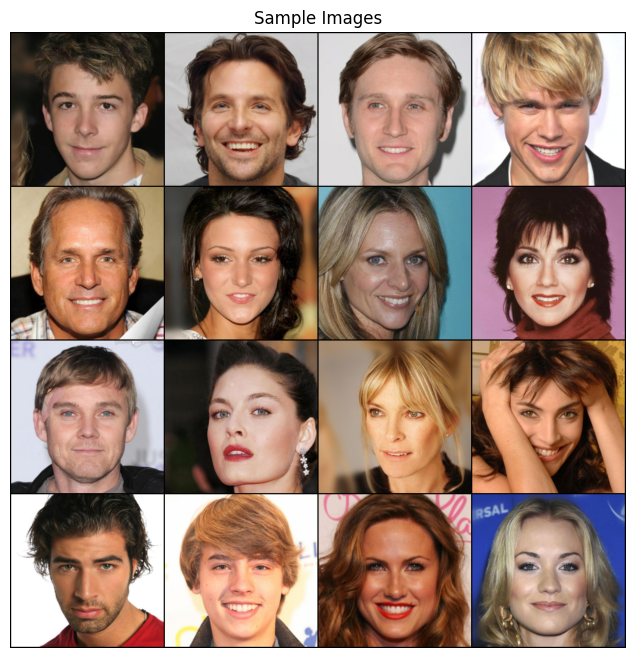

In [11]:
# Testing and Visualizing Data

test_image_dataset_cls = {
    "mnist": MnistDataset,
    "celebhq": CelebDataset,
  }.get(dataset_params["name"])

test_image_dataset = test_image_dataset_cls(split="train",
                                            image_path=dataset_params["image_path"],
                                            image_size=dataset_params["image_size"],
                                            image_channels=dataset_params["image_channels"],
                                            use_latents=False)

test_dataloader = DataLoader(test_image_dataset,
                             batch_size=16,
                             shuffle=True,
                             num_workers=os.cpu_count(),
                             pin_memory=True)

images = next(iter(test_dataloader))

grid_img = make_grid(images, nrow=4, normalize=True)
np_img = grid_img.cpu().numpy().transpose((1, 2, 0))

plt.figure(figsize=(8, 8))
plt.imshow(np_img)
plt.axis(False)
plt.title("Sample Images")
plt.show()

**Latent Diffusion**

Diffusion works great for lower resolution images, but once we get to higher resolution images, the UNET has to become exponentially larger, increasing training times and increasing the number of parameters.

**In Latent Diffusion, instead of training diffusion models on images, we train diffusion models on the latent space of an AutoEncoder.** This reduces training costs while maintaining a high quality of generated images.

When **training** a Latent Diffusion model, we first have an AutoEncoder which has an Encoder and Decoder. **The Encoder takes the image in pixel space and generates a latent space representation of the image at a lower resolution.**

**The Decoder then takes the latent space image and generates an image at the original resolution. Then, the entire AutoEncoder is trained using L2 Reconstruction Loss.**

**We then train a Diffusion model in this latent space, in which we take a noise sample and generate an image in the latent space which can then be fed into the trained decoder to generate an image at a higher resolution.**

For this implementation, we will use a VQ-VAE with a discrete latent space as our AutoEncoder.

However, **Reconstruction Loss alone won’t be enough for good results**. When just using reconstruction loss, we will get **blurry results as the MSE value between the input image and reconstruction will still be low, even when results are blurry.**

So, we have to add another term to the loss to help solve this. We can use **perceptual loss** for this.

**Perceptual Loss**

Perceptual loss is a loss function that measures differences in high-level features between images. Instead of comparing raw pixel values, perceptual loss compares feature maps obtained from **intermediate layers of a pre-trained convolutional neural network** (such as VGG). These features capture more abstract aspects of the image such as **edges, textures, and overall structure.**

Since these intermediate features better represent how humans perceive images, using perceptual loss tends to produce results that are visually more appealing and closer to human perception. **This helps avoid issues like overly smooth or blurry images that can result from strict pixel-wise losses.**

When using perceptual loss, both the target image and the generated image are passed through a pre-trained network. Instead of using the final classification output, activations from one or more intermediate layers are extracted.

The loss is computed as the square of differences (L2) between the feature representations of the generated image and the target image. This difference is what the network is optimized to minimize during training.

By minimizing the perceptual loss, the network learns to produce images that match the high-level structure and details of the target image, resulting in outputs that are perceptually closer to what a human would expect.

In latent diffusion, we feed the input image and the reconstructed image from the AutoEncoder as a pair of images to the network that gives us a measure $d$ of perceptual distance.

For 2 images that are the same, $d$ will be equal to $0$. The higher the value of $d$, the higher the perceptual difference.

This metric is called **Learned Perceptual Image Patch Similarity Metric (LPIPS).** We can then add this to the L2 reconstruction loss in the training of the AutoEncoder.

In [12]:
def spatial_average(in_tens, keepdim=True):
  # Compute the mean over the height and width

  # (batch_size, 1, 1, 1) with keepdim=True
  # (batch_size, 1) with keepdim=False
  return in_tens.mean([2, 3], keepdim=keepdim)

In [13]:
# Extract feature maps at various depths for perceptual loss calculations
# The similarity of images is measured in feature space rather than just pixel space
class vgg16(nn.Module):
  def __init__(self, requires_grad=False, pretrained=True):
    super().__init__()

    vgg_pretrained_features = models.vgg16(pretrained=pretrained).features

    self.slice1 = torch.nn.Sequential()
    self.slice2 = torch.nn.Sequential()
    self.slice3 = torch.nn.Sequential()
    self.slice4 = torch.nn.Sequential()
    self.slice5 = torch.nn.Sequential()

    self.N_slices = 5

    for x in range(4):
      # (batch_size, 3, h, w) -> (batch_size, 64, h, w)
      self.slice1.add_module(str(x), vgg_pretrained_features[x])

    for x in range(4, 9):
      # (batch_size, 64, h, w) -> (batch_size, 128, h / 2, w / 2)
      self.slice2.add_module(str(x), vgg_pretrained_features[x])

    for x in range(9, 16):
      # (batch_size, 128, h / 2, w / 2) -> (batch_size, 256, h / 4, w / 4)
      self.slice3.add_module(str(x), vgg_pretrained_features[x])

    for x in range(16, 23):
      # (batch_size, 256, h / 4, w / 4) -> (batch_size, 512, h / 8, w / 8)
      self.slice4.add_module(str(x), vgg_pretrained_features[x])

    for x in range(23, 30):
      # (batch_size, 512, h / 8, w / 8) -> (batch_size, 512, h / 16, w / 16)
      self.slice5.add_module(str(x), vgg_pretrained_features[x])

    # Freeze vgg model
    if not requires_grad:
      for param in self.parameters():
        param.requires_grad = False

  def forward(self, x):
    # Return the output of vgg features
    h = self.slice1(x)
    h_relu1_2 = h

    h = self.slice2(h)
    h_relu2_2 = h

    h = self.slice3(h)
    h_relu3_3 = h

    h = self.slice4(h)
    h_relu4_3 = h

    h = self.slice5(h)
    h_relu5_3 = h

    vgg_outputs = namedtuple("VggOutputs", ["relu1_2", "relu2_2", "relu3_3", "relu4_3", "relu5_3"])
    out = vgg_outputs(h_relu1_2, h_relu2_2, h_relu3_3, h_relu4_3, h_relu5_3)

    return out

In [14]:
class ScalingLayer(nn.Module):
  def __init__(self):
    super().__init__()
    # Imagnet normalization for (0-1)
    # mean = [0.485, 0.456, 0.406]
    # std = [0.229, 0.224, 0.225]
    self.register_buffer("shift", torch.Tensor([-.030, -.088, -.188])[None, :, None, None]) # (1, 3, 1, 1)
    self.register_buffer("scale", torch.Tensor([.458, .448, .450])[None, :, None, None]) # (1, 3, 1, 1)

  def forward(self, inp):
    return (inp - self.shift) / self.scale # (batch_size, 3, h, w)

In [15]:
class NetLinLayer(nn.Module):
  """
  Applies a linear transformation to the features using a 1×1 convolution
  """
  def __init__(self,
               in_channels,
               out_channels=1,
               use_dropout=False):
    super().__init__()

    layers = [nn.Dropout(), ] if (use_dropout) else []
    layers += [nn.Conv2d(in_channels=in_channels,
                         out_channels=out_channels,
                         kernel_size=1,
                         stride=1,
                         padding=0,
                         bias=False), ]

    self.model = nn.Sequential(*layers)

  def forward(self, x):
    out = self.model(x)
    return out

In [16]:
# Learned Perceptual Image Patch Similarity Metric (LPIPS)
class LPIPS(nn.Module):
  def __init__(self, net="vgg", version="0.1", use_dropout=True):
    super().__init__()

    # ImageNet Normalization
    self.scaling_layer = ScalingLayer()

    # Instantiate the VGG Model
    self.channels = [64, 128, 256, 512, 512]
    self.num_channels = len(self.channels)
    self.net = vgg16(pretrained=True, requires_grad=False) # Get pretrained VGG and freeze the weights

    # Add 1x1 conv layers
    self.lin0 = NetLinLayer(in_channels=self.channels[0],
                            out_channels=1,
                            use_dropout=use_dropout)
    self.lin1 = NetLinLayer(in_channels=self.channels[1],
                            out_channels=1,
                            use_dropout=use_dropout)
    self.lin2 = NetLinLayer(in_channels=self.channels[2],
                            out_channels=1,
                            use_dropout=use_dropout)
    self.lin3 = NetLinLayer(in_channels=self.channels[3],
                            out_channels=1,
                            use_dropout=use_dropout)
    self.lin4 = NetLinLayer(in_channels=self.channels[4],
                            out_channels=1,
                            use_dropout=use_dropout)

    self.lins = nn.ModuleList([self.lin0, self.lin1, self.lin2, self.lin3, self.lin4])

    # Load the weights of the trained LPIPS model with VGG weights
    model_path = os.path.abspath(os.path.join("weights", f"v{version}", f"{net}.pth"))
    print(f"Loading model from: {model_path}")
    self.load_state_dict(torch.load(model_path, map_location=device), strict=False)

    # Freeze all parameters and gradient calculations
    self.eval()
    for param in self.parameters():
      param.requires_grad = False

  def forward(self, in0, in1, normalize=False):
    # in0 shape: (batch_size, 3, h, w)
    # in1 shape: (batch_size, 3, h, w)

    # Scale the inputs to [-1, +1]
    if normalize:
      in0 = 2 * in0 - 1
      in1 = 2 * in1 - 1

    # Normalize the inputs according to the ImageNet normalization
    in0_input, in1_input = self.scaling_layer(in0), self.scaling_layer(in1) # (batch_size, 3, h, w) each

    # Get the VGG outputs for image0 and image1
    outs0, outs1 = self.net.forward(in0_input), self.net.forward(in1_input) # (batch_size, 512, h / 16, w / 16) each
    feats0, feats1, diffs = {}, {}, {}

    # Normalize and compute squares of difference for each layer output
    for channel_idx in range(self.num_channels):
      feats0[channel_idx], feats1[channel_idx] = F.normalize(outs0[channel_idx], dim=1), F.normalize(outs1[channel_idx])
      diffs[channel_idx] = (feats0[channel_idx] - feats1[channel_idx])**2

    # 1x1 Convolution followed by a spatial average on the square differences
    res = [spatial_average(self.lins[channel_idx](diffs[channel_idx]), keepdim=True) for channel_idx in range(self.num_channels)] # (batch_size, 1, 1, 1) for each channel
    val = 0

    # Add up the results of each layer
    for i in range(self.num_channels):
      val += res[i]

    # Batch of scalars for the perceptual similarity between in0 and in1. A lower value means the images are more similar in terms of high-level features.
    return val

In [17]:
def get_time_embedding(time_steps, temb_dim):
  """
  Convert time steps tensor into an embedding using the sinusoidal time embedding formula
  time_steps: 1D tensor of length batch size
  temb_dim: Dimension of the embedding
  """
  assert temb_dim % 2 == 0, "time embedding dimension must be divisible by 2"

  # factor = 10000^(2i/d_model)
  factor = 10000 ** ((torch.arange(
      start=0, end=temb_dim // 2, dtype=torch.float32, device=time_steps.device) / (temb_dim // 2))
  )

  t_emb = time_steps.unsqueeze(dim=-1).repeat(1, temb_dim // 2) / factor
  t_emb = torch.cat([torch.sin(t_emb), torch.cos(t_emb)], dim=-1)

  return t_emb # (batch_size, temb_dim)

In [18]:
class DownBlock(nn.Module):
  """
  Down conv block with attention.
  1. Resnet block with time embedding
  2. Attention block
  3. Downsample

  in_channels: Number of channels in the input feature map.
	out_channels: Number of channels produced by this block.
	t_emb_dim: Dimension of the time embedding. Only use for UNet for Diffusion. In an AutoEncoder, set it to None.
	down_sample: Whether to apply downsampling at the end.
	num_heads: Number of attention heads (used if attention is enabled).
	num_layers: How many sub-blocks to apply in sequence.
	attn: Whether to apply self-attention
	norm_channels: Number of groups for GroupNorm.
	cross_attn: Whether to apply cross-attention.
  context_dim: If performing cross-attention, provide a context_dim for extra conditioning context.
  """
  def __init__(self,
               in_channels,
               out_channels,
               t_emb_dim,
               down_sample,
               num_heads,
               num_layers,
               attn,
               norm_channels,
               cross_attn=False,
               context_dim=None):
    super().__init__()

    self.num_layers = num_layers
    self.down_sample = down_sample
    self.attn = attn
    self.context_dim = context_dim
    self.cross_attn = cross_attn
    self.t_emb_dim = t_emb_dim

    self.resnet_conv_first = nn.ModuleList([
        nn.Sequential(
            nn.GroupNorm(norm_channels, in_channels if i == 0 else out_channels), # Normalizes over channels. For the first sub-block, the in_channels=in_channels, else out_channels
            nn.SiLU(),
            nn.Conv2d(in_channels=(in_channels if i == 0 else out_channels),
                      out_channels=out_channels,
                      kernel_size=3,
                      stride=1,
                      padding=1) # (batch_size, c, h, w) -> (batch_size, out_channels, h, w)
        ) for i in range(num_layers)
    ])

    # Only add the time embedding for diffusion and not AutoEncoder
    if self.t_emb_dim is not None:
      self.t_emb_layers = nn.ModuleList([
          nn.Sequential(
              nn.SiLU(),
              nn.Linear(in_features=self.t_emb_dim, out_features=out_channels) # (batch_size, t_emb_dim) -> (batch_size, out_channels)
          ) for i in range(num_layers)
      ])

    self.resnet_conv_second = nn.ModuleList([
        nn.Sequential(
            nn.GroupNorm(norm_channels, out_channels),
            nn.SiLU(),
            nn.Conv2d(in_channels=out_channels,
                      out_channels=out_channels,
                      kernel_size=3,
                      stride=1,
                      padding=1) # (batch_size, out_channels, h, w) -> (batch_size, out_channels, h, w)
        ) for i in range(num_layers)
    ])

    self.residual_input_conv = nn.ModuleList([
        nn.Conv2d(in_channels=(in_channels if i == 0 else out_channels),
                  out_channels=out_channels,
                  kernel_size=1,
                  stride=1,
                  padding=0) # (batch_size, in_channels, h, w) -> (batch_size, out_channels, h, w)
        for i in range(num_layers)
    ])

    if self.attn:
      self.attention_norms = nn.ModuleList([
          nn.GroupNorm(norm_channels, out_channels)
          for i in range(num_layers)
      ])

      self.attentions = nn.ModuleList([
          nn.MultiheadAttention(embed_dim=out_channels, num_heads=num_heads, batch_first=True)
          for i in range(num_layers)
      ])

    # Cross attention for text conditioning
    if self.cross_attn:
      assert context_dim is not None, "Context Dimension must be passed for cross attention"

      self.cross_attention_norms = nn.ModuleList([
          nn.GroupNorm(norm_channels, out_channels)
          for i in range(num_layers)
      ])

      self.cross_attentions = nn.ModuleList([
          nn.MultiheadAttention(embed_dim=out_channels, num_heads=num_heads, batch_first=True)
          for i in range(num_layers)
      ])

      self.context_proj = nn.ModuleList([
          nn.Linear(in_features=context_dim, out_features=out_channels)
          for i in range(num_layers)
      ])

    # Down sample by a factor of 2
    self.down_sample_conv = nn.Conv2d(in_channels=out_channels,
                                      out_channels=out_channels,
                                      kernel_size=4,
                                      stride=2,
                                      padding=1) if self.down_sample else nn.Identity() # (batch_size, out_channels, h / 2, w / 2)

  def forward(self, x, t_emb=None, context=None):
    out = x
    for i in range(self.num_layers):
      # Resnet block of UNET
      resnet_input = out # (batch_size, c, h, w)

      out = self.resnet_conv_first[i](out) # (batch_size, out_channels, h, w)

      # Only add the time embedding for diffusion and not AutoEncoder
      if self.t_emb_dim is not None:
        # Add the embeddings for timesteps - (batch_size, t_emb_dim) -> (batch_size, out_channels, 1, 1)
        out = out + self.t_emb_layers[i](t_emb).unsqueeze(dim=-1).unsqueeze(dim=-1) # (batch_size, out_channels, h, w)

      out = self.resnet_conv_second[i](out) # (batch_size, out_channels, h, w) -> (batch_size, out_channels, h, w)

      # Residual Connection
      out = out + self.residual_input_conv[i](resnet_input) # (batch_size, out_channels, h, w)

      # Only do for Diffusion and not for AutoEncoder
      if self.attn:
        # Attention block of UNET
        batch_size, channels, h, w = out.shape # (batch_size, out_channels, h, w)

        in_attn = out.reshape(batch_size, channels, h * w) # (batch_size, out_channels, h * w)
        in_attn = self.attention_norms[i](in_attn)
        in_attn = in_attn.transpose(1, 2) # (batch_size, h * w, out_channels)

        # Self-Attention
        out_attn, attn_weights = self.attentions[i](in_attn, in_attn, in_attn)
        out_attn = out_attn.transpose(1, 2).reshape(batch_size, channels, h, w) # (batch_size, out_channels h, w)

        # Skip connection
        out = out + out_attn # (batch_size, out_channels h, w)

      if self.cross_attn:
        assert context is not None, "context cannot be None if cross attention layers are used"

        batch_size, channels, h, w = out.shape # (batch_size, out_channels, h, w)

        in_attn = out.reshape(batch_size, channels, h * w) # (batch_size, out_channels, h * w)
        in_attn = self.cross_attention_norms[i](in_attn)
        in_attn = in_attn.transpose(1, 2) # (batch_size, h * w, out_channels)

        assert context.shape[0] == x.shape[0] and context.shape[-1] == self.context_dim # Make sure the batch_size and context_dim match with the model's parameters
        context_proj = self.context_proj[i](context) # (batch_size, seq_len, context_dim) -> (batch_size, seq_len, out_channels)

        # Cross-Attention
        out_attn, attn_weights = self.cross_attentions[i](in_attn, context_proj, context_proj) # (batch_size, h * w, out_channels)
        out_attn = out_attn.transpose(1, 2).reshape(batch_size, channels, h, w) # (batch_size, out_channels, h, w)

        # Skip Connection
        out = out + out_attn # (batch_size, out_channels, h, w)

    # Downsampling
    out = self.down_sample_conv(out) # (batch_size, out_channels, h / 2, w / 2)
    return out

In [19]:
class MidBlock(nn.Module):
  """
  Mid conv block with attention.
  1. Resnet block with time embedding
  2. Attention block
  3. Resnet block with time embedding

  in_channels: Number of channels in the input feature map.
	out_channels: Number of channels produced by this block.
	t_emb_dim: Dimension of the time embedding. Only use for UNet for Diffusion. In an AutoEncoder, set it to None.
	num_heads: Number of attention heads (used if attention is enabled).
	num_layers: How many sub-blocks to apply in sequence.
	norm_channels: Number of groups for GroupNorm.
	cross_attn: Whether to apply cross-attention.
  context_dim: If performing cross-attention, provide a context_dim for extra conditioning context.
  """
  def __init__(self,
               in_channels,
               out_channels,
               t_emb_dim,
               num_heads,
               num_layers,
               norm_channels,
               cross_attn=None,
               context_dim=None):
    super().__init__()

    self.num_layers = num_layers
    self.t_emb_dim = t_emb_dim
    self.context_dim = context_dim
    self.cross_attn = cross_attn

    self.resnet_conv_first = nn.ModuleList([
        nn.Sequential(
            nn.GroupNorm(norm_channels, in_channels if i == 0 else out_channels), # Normalizes over channels. For the first sub-block, the in_channels=in_channels, else out_channels
            nn.SiLU(),
            nn.Conv2d(in_channels=(in_channels if i == 0 else out_channels),
                      out_channels=out_channels,
                      kernel_size=3,
                      stride=1,
                      padding=1) # (batch_size, c, h, w) -> (batch_size, out_channels, h, w)
        ) for i in range(num_layers + 1)
    ])

    # Only add the time embedding for diffusion and not AutoEncoder
    if self.t_emb_dim is not None:
      self.t_emb_layers = nn.ModuleList([
          nn.Sequential(
              nn.SiLU(),
              nn.Linear(in_features=self.t_emb_dim, out_features=out_channels) # (batch_size, t_emb_dim) -> (batch_size, out_channels)
          ) for i in range(num_layers + 1)
      ])

    self.resnet_conv_second = nn.ModuleList([
        nn.Sequential(
            nn.GroupNorm(norm_channels, out_channels),
            nn.SiLU(),
            nn.Conv2d(in_channels=out_channels,
                      out_channels=out_channels,
                      kernel_size=3,
                      stride=1,
                      padding=1) # (batch_size, out_channels, h, w) -> (batch_size, out_channels, h, w)
        ) for i in range(num_layers + 1)
    ])

    self.residual_input_conv = nn.ModuleList([
        nn.Conv2d(in_channels=(in_channels if i == 0 else out_channels),
                  out_channels=out_channels,
                  kernel_size=1,
                  stride=1,
                  padding=0) # (batch_size, in_channels, h, w) -> (batch_size, out_channels, h, w)
        for i in range(num_layers + 1)
    ])

    self.attention_norms = nn.ModuleList([
        nn.GroupNorm(norm_channels, out_channels)
        for i in range(num_layers)
    ])

    self.attentions = nn.ModuleList([
        nn.MultiheadAttention(embed_dim=out_channels, num_heads=num_heads, batch_first=True)
        for i in range(num_layers)
    ])

    # Cross attention for text conditioning
    if self.cross_attn:
      assert context_dim is not None, "Context Dimension must be passed for cross attention"

      self.cross_attention_norms = nn.ModuleList([
          nn.GroupNorm(norm_channels, out_channels)
          for i in range(num_layers)
      ])

      self.cross_attentions = nn.ModuleList([
          nn.MultiheadAttention(embed_dim=out_channels, num_heads=num_heads, batch_first=True)
          for i in range(num_layers)
      ])

      self.context_proj = nn.ModuleList([
          nn.Linear(in_features=context_dim, out_features=out_channels)
          for i in range(num_layers)
      ])

  def forward(self, x, t_emb=None, context=None):
    out = x

    # First ResNet block
    resnet_input = out # (batch_size, c, h, w)
    out = self.resnet_conv_first[0](out) # (batch_size, out_channels, h, w)

    # Only add the time embedding for diffusion and not AutoEncoder
    if self.t_emb_dim is not None:
      # Add the embeddings for timesteps - (batch_size, t_emb_dim) -> (batch_size, out_channels, 1, 1)
      out = out + self.t_emb_layers[0](t_emb).unsqueeze(dim=-1).unsqueeze(dim=-1) # (batch_size, out_channels, h, w)

    out = self.resnet_conv_second[0](out) # (batch_size, out_channels, h, w) -> (batch_size, out_channels, h, w)

    # Residual Connection
    out = out + self.residual_input_conv[0](resnet_input) # (batch_size, out_channels, h, w)

    for i in range(self.num_layers):
      # Attention Block
      batch_size, channels, h, w = out.shape # (batch_size, out_channels, h, w)

      # Do for both Diffusion and AutoEncoder
      in_attn = out.reshape(batch_size, channels, h * w) # (batch_size, out_channels, h * w)
      in_attn = self.attention_norms[i](in_attn)
      in_attn = in_attn.transpose(1, 2) # (batch_size, h * w, out_channels)

      # Self-Attention
      out_attn, attn_weights = self.attentions[i](in_attn, in_attn, in_attn)
      out_attn = out_attn.transpose(1, 2).reshape(batch_size, channels, h, w)

      # Skip connection
      out = out + out_attn # (batch_size, out_channels h, w)

      if self.cross_attn:
        assert context is not None, "context cannot be None if cross attention layers are used"
        batch_size, channels, h, w = out.shape

        in_attn = out.reshape(batch_size, channels, h * w) # (batch_size, out_channels, h * w)
        in_attn = self.cross_attention_norms[i](in_attn)
        in_attn = in_attn.transpose(1, 2) # (batch_size, h * w, out_channels)

        assert context.shape[0] == x.shape[0] and context.shape[-1] == self.context_dim # Make sure the batch_size and context_dim match with the model's parameters
        context_proj = self.context_proj[i](context) # (batch_size, seq_len, context_dim) -> (batch_size, seq_len, context_dim)

        # Cross-Attention
        out_attn, attn_weights = self.cross_attentions[i](in_attn, context_proj, context_proj)
        out_attn = out_attn.transpose(1, 2).reshape(batch_size, channels, h, w) # (batch_size, out_channels, h, w)

        # Skip Connection
        out = out + out_attn # (batch_size, out_channels h, w)

      # Resnet Block
      resnet_input = out
      out = self.resnet_conv_first[i + 1](out) # (batch_size, out_channels h, w) -> (batch_size, out_channels h, w)

      # Only add the time embedding for diffusion and not AutoEncoder
      if self.t_emb_dim is not None:
        # Add the embeddings for timesteps - (batch_size, t_emb_dim) -> (batch_size, out_channels, 1, 1)
        out = out + self.t_emb_layers[i + 1](t_emb).unsqueeze(dim=-1).unsqueeze(dim=-1) # (batch_size, out_channels h, w)

      out = self.resnet_conv_second[i + 1](out) # (batch_size, out_channels h, w) -> (batch_size, out_channels h, w)

      # Residual Connection
      out = out + self.residual_input_conv[i + 1](resnet_input) # (batch_size, out_channels, h, w)

    return out

In [20]:
class UpBlock(nn.Module):
  """
  Up conv block with attention.
  1. Upsample
  1. Concatenate Down block output
  2. Resnet block with time embedding
  3. Attention Block

  in_channels: Number of channels in the input feature map.
	out_channels: Number of channels produced by this block.
	t_emb_dim: Dimension of the time embedding. Only use for UNet for Diffusion. In an AutoEncoder, set it to None.
	up_sample: Whether to apply upsampling at the end.
	num_heads: Number of attention heads (used if attention is enabled).
	num_layers: How many sub-blocks to apply in sequence.
	attn: Whether to apply self-attention
	norm_channels: Number of groups for GroupNorm.
  """
  def __init__(self,
               in_channels,
               out_channels,
               t_emb_dim,
               up_sample,
               num_heads,
               num_layers,
               attn,
               norm_channels):
    super().__init__()

    self.num_layers = num_layers
    self.up_sample = up_sample
    self.t_emb_dim = t_emb_dim
    self.attn = attn

    # Upsample by a factor of 2
    self.up_sample_conv = nn.ConvTranspose2d(in_channels=in_channels,
                                             out_channels=in_channels,
                                             kernel_size=4,
                                             stride=2,
                                             padding = 1) if self.up_sample else nn.Identity() # (batch_size, c, h * 2, w * 2)

    self.resnet_conv_first = nn.ModuleList([
        nn.Sequential(
            nn.GroupNorm(norm_channels, in_channels if i == 0 else out_channels), # Normalizes over channels. For the first sub-block, the in_channels=in_channels, else out_channels
            nn.SiLU(),
            nn.Conv2d(in_channels=(in_channels if i == 0 else out_channels),
                      out_channels=out_channels,
                      kernel_size=3,
                      stride=1,
                      padding=1) # (batch_size, c, h, w) -> (batch_size, out_channels, h, w)
        ) for i in range(num_layers)
    ])

    # Only add the time embedding for diffusion and not AutoEncoder
    if self.t_emb_dim is not None:
      self.t_emb_layers = nn.ModuleList([
          nn.Sequential(
              nn.SiLU(),
              nn.Linear(in_features=self.t_emb_dim, out_features=out_channels) # (batch_size, t_emb_dim) -> (batch_size, out_channels)
          ) for i in range(num_layers)
      ])

    self.resnet_conv_second = nn.ModuleList([
        nn.Sequential(
            nn.GroupNorm(norm_channels, out_channels),
            nn.SiLU(),
            nn.Conv2d(in_channels=out_channels,
                      out_channels=out_channels,
                      kernel_size=3,
                      stride=1,
                      padding=1) # (batch_size, out_channels, h, w) -> (batch_size, out_channels, h, w)
        ) for i in range(num_layers)
    ])

    self.residual_input_conv = nn.ModuleList([
        nn.Conv2d(in_channels=(in_channels if i == 0 else out_channels),
                  out_channels=out_channels,
                  kernel_size=1,
                  stride=1,
                  padding=0) # (batch_size, in_channels, h, w) -> (batch_size, out_channels, h, w)
        for i in range(num_layers)
    ])

    if self.attn:
      self.attention_norms = nn.ModuleList([
          nn.GroupNorm(norm_channels, out_channels)
          for i in range(num_layers)
      ])

      self.attentions = nn.ModuleList([
          nn.MultiheadAttention(embed_dim=out_channels, num_heads=num_heads, batch_first=True)
          for i in range(num_layers)
      ])

  def forward(self, x, out_down=None, t_emb=None):
    # x shape: (batch_size, c, h, w)

    # Upsample
    x = self.up_sample_conv(x) # (batch_size, c, h, w) -> (batch_size, c, h * 2, w * 2)

    # *Only do for diffusion
    # Concatenate with the output of respective DownBlock
    if out_down is not None:
      x = torch.cat([x, out_down], dim=1) # (batch_size, c, h * 2, w * 2) -> (batch_size, c * 2, h * 2, w * 2)

    out = x # (batch_size, c, h * 2, w * 2)

    for i in range(self.num_layers):
      # Resnet block
      resnet_input = out
      out = self.resnet_conv_first[i](out) # (batch_size, in_channels, h * 2, w * 2) -> (batch_size, out_channels, h * 2, w * 2)

      # Only add the time embedding for diffusion and not AutoEncoder
      if self.t_emb_dim is not None:
        # Add the embeddings for timesteps - (batch_size, t_emb_dim) -> (batch_size, out_channels, 1, 1)
        out = out + self.t_emb_layers[i](t_emb).unsqueeze(dim=-1).unsqueeze(dim=-1) # (batch_size, out_channels, h * 2, w * 2)

      out = self.resnet_conv_second[i](out) # (batch_size, out_channels, h * 2, w * 2) -> (batch_size, out_channels, h * 2, w * 2)

      # Residual Connection
      out = out + self.residual_input_conv[i](resnet_input) # (batch_size, out_channels, h * 2, w * 2)

      # Only do for Diffusion and not for AutoEncoder
      if self.attn:
        # Attention block of UNET
        batch_size, channels, h, w = out.shape

        in_attn = out.reshape(batch_size, channels, h * w) # (batch_size, out_channels, h * w * 4)
        in_attn = self.attention_norms[i](in_attn)
        in_attn = in_attn.transpose(1, 2) # (batch_size, h * w * 4, out_channels)

        # Self-Attention
        out_attn, attn_weights = self.attentions[i](in_attn, in_attn, in_attn)
        out_attn = out_attn.transpose(1, 2).reshape(batch_size, channels, h, w) # (batch_size, out_channels h * 2, w * 2)

        # Skip connection
        out = out + out_attn # (batch_size, out_channels h * 2, w * 2)

    return out # (batch_size, out_channels h * 2, w * 2)

In [21]:
class UpBlockUNet(nn.Module):
  """
  Up conv block with attention.
  1. Upsample
  1. Concatenate Down block output
  2. Resnet block with time embedding
  3. Attention Block

  in_channels: Number of channels in the input feature map. (It is passed in multiplied by 2 for concatenation with DownBlock output)
	out_channels: Number of channels produced by this block.
	t_emb_dim: Dimension of the time embedding. Only use for UNet for Diffusion. In an AutoEncoder, set it to None.
	up_sample: Whether to apply upsampling at the end.
	num_heads: Number of attention heads (used if attention is enabled).
	num_layers: How many sub-blocks to apply in sequence.
	norm_channels: Number of groups for GroupNorm.
	cross_attn: Whether to apply cross-attention.
  context_dim: If performing cross-attention, provide a context_dim for extra conditioning context.
  """
  def __init__(self,
               in_channels,
               out_channels,
               t_emb_dim,
               up_sample,
               num_heads,
               num_layers,
               norm_channels,
               cross_attn=False,
               context_dim=None):
    super().__init__()

    self.num_layers = num_layers
    self.up_sample = up_sample
    self.t_emb_dim = t_emb_dim
    self.cross_attn = cross_attn
    self.context_dim = context_dim

    self.up_sample_conv = nn.ConvTranspose2d(in_channels=(in_channels // 2),
                                             out_channels=(in_channels // 2),
                                             kernel_size=4,
                                             stride=2,
                                             padding=1) if self.up_sample else nn.Identity() # (batch_size, in_channels // 2, h * 2, w * 2)

    self.resnet_conv_first = nn.ModuleList([
        nn.Sequential(
            nn.GroupNorm(norm_channels, in_channels if i == 0 else out_channels), # Normalizes over channels. For the first sub-block, the in_channels=in_channels, else out_channels
            nn.SiLU(),
            nn.Conv2d(in_channels=(in_channels if i == 0 else out_channels),
                      out_channels=out_channels,
                      kernel_size=3,
                      stride=1,
                      padding=1) # (batch_size, in_channels, h * 2, w. * 2) -> (batch_size, out_channels, h * 2, w * 2) - Starts at in_channels and not in_channels // 2 because of concatenation
        ) for i in range(num_layers)
    ])

    # Only add the time embedding if needed for UNET in diffusion
    # Do not add the time embedding in the AutoEncoder
    if self.t_emb_dim is not None:
      self.t_emb_layers = nn.ModuleList([
          nn.Sequential(
              nn.SiLU(),
              nn.Linear(in_features=self.t_emb_dim, out_features=out_channels) # (batch_size, t_emb_dim) -> (batch_size, out_channels)
          ) for i in range(num_layers)
      ])

    self.resnet_conv_second = nn.ModuleList([
        nn.Sequential(
            nn.GroupNorm(norm_channels, out_channels),
            nn.SiLU(),
            nn.Conv2d(in_channels=out_channels,
                      out_channels=out_channels,
                      kernel_size=3,
                      stride=1,
                      padding=1) # (batch_size, out_channels, h * 2, w * 2) -> (batch_size, out_channels, h * 2, w * 2)
        ) for i in range(num_layers)
    ])

    self.residual_input_conv = nn.ModuleList([
        nn.Conv2d(in_channels=(in_channels if i == 0 else out_channels),
                  out_channels=out_channels,
                  kernel_size=1,
                  stride=1,
                  padding=0)
        for i in range(num_layers) # (batch_size, in_channels, h * 2, w * 2) -> (batch_size, out_channels, h * 2, w * 2)
    ])

    self.attention_norms = nn.ModuleList([
        nn.GroupNorm(norm_channels, out_channels)
        for i in range(num_layers)
    ])

    self.attentions = nn.ModuleList([
        nn.MultiheadAttention(embed_dim=out_channels, num_heads=num_heads, batch_first=True)
        for i in range(num_layers)
    ])

    # Cross attention for text conditioning
    if self.cross_attn:
      assert context_dim is not None, "Context Dimension must be passed for cross attention"

      self.cross_attention_norms = nn.ModuleList([
          nn.GroupNorm(norm_channels, out_channels)
          for i in range(num_layers)
      ])

      self.cross_attentions = nn.ModuleList([
          nn.MultiheadAttention(embed_dim=out_channels, num_heads=num_heads, batch_first=True)
          for i in range(num_layers)
      ])

      self.context_proj = nn.ModuleList([
          nn.Linear(in_features=context_dim, out_features=out_channels)
          for i in range(num_layers)
      ])

  def forward(self, x, out_down=None, t_emb=None, context=None):
    # x shape: (batch_size, in_channels // 2, h, w)

    # Upsample
    x = self.up_sample_conv(x) # (batch_size, in_channels // 2, h, w) -> (batch_size, in_channels // 2, h * 2, w * 2)

    # Concatenate with the output of respective DownBlock
    if out_down is not None:
      x = torch.cat([x, out_down], dim=1) # (batch_size, in_channels // 2, h * 2, w * 2) -> (batch_size, in_channels, h * 2, w * 2)

    out = x # (batch_size, in_channels, h * 2, w * 2)
    for i in range(self.num_layers):
      # Resnet block
      resnet_input = out

      out = self.resnet_conv_first[i](out) # (batch_size, in_channels, h * 2, w * 2) -> (batch_size, out_channels, h * 2, w * 2)

      if self.t_emb_dim is not None:
        # Add the embeddings for timesteps - (batch_size, t_emb_dim) -> (batch_size, out_channels, 1, 1)
        out = out + self.t_emb_layers[i](t_emb).unsqueeze(dim=-1).unsqueeze(dim=-1) # (batch_size, out_channels, h * 2, w * 2)

      out = self.resnet_conv_second[i](out) # (batch_size, out_channels, h * 2, w * 2) -> (batch_size, out_channels, h * 2, w * 2)

      # Residual Connection
      out = out + self.residual_input_conv[i](resnet_input) # (batch_size, out_channels, h * 2, w * 2)

      # Attention block of UNET
      batch_size, channels, h, w = out.shape # (batch_size, out_channels, h * 2, w * 2)

      in_attn = out.reshape(batch_size, channels, h * w) # (batch_size, out_channels, h * w * 4)
      in_attn = self.attention_norms[i](in_attn)
      in_attn = in_attn.transpose(1, 2) # (batch_size, h * w * 4, out_channels)

      # Self-Attention
      out_attn, attn_weights = self.attentions[i](in_attn, in_attn, in_attn)
      out_attn = out_attn.transpose(1, 2).reshape(batch_size, channels, h, w) # (batch_size, out_channels h * 2, w * 2)

      # Skip connection
      out = out + out_attn # (batch_size, out_channels h * 2, w * 2)

      if self.cross_attn:
        assert context is not None, "context cannot be None if cross attention layers are used"
        batch_size, channels, h, w = out.shape

        in_attn = out.reshape(batch_size, channels, h * w) # (batch_size, out_channels, h * w * 4)
        in_attn = self.cross_attention_norms[i](in_attn)
        in_attn = in_attn.transpose(1, 2) # (batch_size, h * w * 4, out_channels)

        assert len(context.shape) == 3, "Context shape does not match batch_size, _, context_dim"

        assert context.shape[0] == x.shape[0] and context.shape[-1] == self.context_dim, "Context shape does not match batch_size, _, context_dim" # Make sure the batch_size and context_dim match with the model's parameters
        context_proj = self.context_proj[i](context) # (batch_size, seq_len, context_dim) -> (batch_size, seq_len, context_dim)

        # Cross-Attention
        out_attn, attn_weights = self.cross_attentions[i](in_attn, context_proj, context_proj)
        out_attn = out_attn.transpose(1, 2).reshape(batch_size, channels, h, w) # (batch_size, out_channels, h * 2, w * 2)

        # Skip Connection
        out = out + out_attn # (batch_size, out_channels h * 2, w * 2)

    return out # (batch_size, out_channels h * 2, w * 2)

For the architecture of the AutoEncoder, we will follow an Encoder and Decoder.

The output of ResNet Blocks will be fed into Self-Attention Blocks. The ResNet blocks will look something like this below, with a self-attention at the end:

We also have to add timestep information, which we can add between the conv layers.

The DownBlocks apply the above, but also down sample by a factor of 2 at the end. The output of the last DownBlock is passed to the MidBlock, or bottleneck, which has a ResNet Block, followed by  a Self-Attention and ResNet Block. This is then passed to UpBlock, which first up samples the input by a factor of 2, applies a ResNet Block, and then performs Self-Attention.

We also concatenate the outputs of the downblocks to those of upblocks with similar resolutions. Timestep information is also added to all of the ResNet Blocks after being passed through a linear layer to get the correct shape.

We do not include attention or skip connections between the DownBlocks and UpBlocks in the AutoEncoder.

The Encoder and Decoder will look something like this: (Note that we also got rid of Attention Blocks in the DownBlock and UpBlock)

If we were to design our architecture as a standard VAE, we want to have an Encoder that generates 2x Latent Dimensions as the output size. The first half will work as the mean, and the second half will work as the log-variance. We can then use the reparameterization trick to generate a sample that will be fed into the decoder.

On the other hand, If we were to design our architecture as a VQ-VAE, we would want to have an Encoder that generates Latent Dimensions as the output size. The codebook would have $Codebook \space Size$ elements, but each element would have a size of $Latent \space Dimension$. We can then get the nearest element from the codebook that matches with the output of the Encoder, and take that quantized vector and feed it into the Decoder.

**When training the VAE or VQ-VAE, we pass in images from the dataset into the encoder. Once the image data has been fully passed through the encoder and been quantized, we are left with a latent vector for each of the images. This is then passed through the decoder to get the final image.**

**We calculate the MSE Loss, perceptual loss (using LPIPS model that uses VGG feature maps), and discriminator (which only kicks in after a certain number of iterations). Over time, the VAE will start generating more accurate reconstructions of the original image.**

In [22]:
class VQVAE(nn.Module):
  def __init__(self, image_channels, model_config):
    super().__init__()

    self.down_channels = model_config["down_channels"]
    self.mid_channels = model_config["mid_channels"]
    self.down_sample = model_config["down_sample"]
    self.num_down_layers = model_config["num_down_layers"]
    self.num_mid_layers = model_config["num_mid_layers"]
    self.num_up_layers = model_config["num_up_layers"]

    # To disable attention in Downblock of Encoder and Upblock of Decoder
    self.attns = model_config["attn_down"]

    # Latent Dimension
    self.z_channels = model_config["z_channels"] # number of channels in the latent representation
    self.codebook_size = model_config["codebook_size"] # number of discrete code vectors available
    self.norm_channels = model_config["norm_channels"]
    self.num_heads = model_config["num_heads"]

    assert self.mid_channels[0] == self.down_channels[-1]
    assert self.mid_channels[-1] == self.down_channels[-1]
    assert len(self.down_sample) == len(self.down_channels) - 1
    assert len(self.attns) == len(self.down_channels) - 1

    # Wherever we downsample in the encoder, use upsampling in the decoder at the corresponding location
    self.up_sample = list(reversed(self.down_sample))

    # Encoder
    self.encoder_conv_in = nn.Conv2d(in_channels=image_channels,
                                     out_channels=self.down_channels[0],
                                     kernel_size=3,
                                     stride=1,
                                     padding=1) # (batch_size, 3, h, w) -> (batch_size, c, h, w)

    # Downblock + Midblock
    self.encoder_layers = nn.ModuleList([])
    for i in range(len(self.down_channels) - 1):
      self.encoder_layers.append(DownBlock(in_channels=self.down_channels[i],
                                           out_channels=self.down_channels[i + 1],
                                           t_emb_dim=None,
                                           down_sample=self.down_sample[i],
                                           num_heads=self.num_heads,
                                           num_layers=self.num_down_layers,
                                           attn=self.attns[i],
                                           norm_channels=self.norm_channels))

    self.encoder_mids = nn.ModuleList([])
    for i in range(len(self.mid_channels) - 1):
      self.encoder_mids.append(MidBlock(in_channels=self.mid_channels[i],
                                        out_channels=self.mid_channels[i + 1],
                                        t_emb_dim=None,
                                        num_heads=self.num_heads,
                                        num_layers=self.num_mid_layers,
                                        norm_channels=self.norm_channels))

    self.encoder_norm_out = nn.GroupNorm(self.norm_channels, self.down_channels[-1])

    self.encoder_conv_out = nn.Conv2d(in_channels=self.down_channels[-1],
                                      out_channels=self.z_channels,
                                      kernel_size=3,
                                      stride=1,
                                      padding=1) # (batch_size, z_channels, h', w')

    # Pre Quantization Convolution
    self.pre_quant_conv = nn.Conv2d(in_channels=self.z_channels,
                                    out_channels=self.z_channels,
                                    kernel_size=1,
                                    stride=1,
                                    padding=0) # (batch_size, z_channels, h', w')

    # Codebook Vectors
    self.embedding = nn.Embedding(self.codebook_size, self.z_channels) # (codebook_size, z_channels)

    # Decoder

    # Post Quantization Convolution
    self.post_quant_conv = nn.Conv2d(in_channels=self.z_channels,
                                     out_channels=self.z_channels,
                                     kernel_size=1,
                                     stride=1,
                                     padding=0) # (batch_size, z_channels, h', w')

    self.decoder_conv_in = nn.Conv2d(in_channels=self.z_channels,
                                     out_channels=self.mid_channels[-1],
                                     kernel_size=3,
                                     stride=1,
                                     padding=1) # (batch_size, c, h', w')

    # Midblock + Upblock
    self.decoder_mids = nn.ModuleList([])
    for i in reversed(range(1, len(self.mid_channels))):
      self.decoder_mids.append(MidBlock(in_channels=self.mid_channels[i],
                                        out_channels=self.mid_channels[i - 1],
                                        t_emb_dim=None,
                                        num_heads=self.num_heads,
                                        num_layers=self.num_mid_layers,
                                        norm_channels=self.norm_channels))

    self.decoder_layers = nn.ModuleList([])
    for i in reversed(range(1, len(self.down_channels))):
      self.decoder_layers.append(UpBlock(in_channels=self.down_channels[i],
                                         out_channels=self.down_channels[i - 1],
                                         t_emb_dim=None,
                                         up_sample=self.down_sample[i - 1],
                                         num_heads=self.num_heads,
                                         num_layers=self.num_up_layers,
                                         attn=self.attns[i - 1],
                                         norm_channels=self.norm_channels))

    self.decoder_norm_out = nn.GroupNorm(self.norm_channels, self.down_channels[0])

    self.decoder_conv_out = nn.Conv2d(in_channels=self.down_channels[0],
                                      out_channels=image_channels,
                                      kernel_size=3,
                                      stride=1,
                                      padding=1) # (batch_size, c, h, w)

  def quantize(self, x):
    batch_size, c, h, w = x.shape # (batch_size, z_channels, h, w)

    x = x.permute(0, 2, 3, 1) # (batch_size, z_channels, h, w) -> (batch_size, h, w, z_channels)
    x = x.reshape(batch_size, -1, c) # (batch_size, h, w, z_channels) -> (batch_size, h * w, z_channels)

    # Find the nearest codebook vector with distance between (batch_size, h * w, z_channels) and (batch_size, code_book_size, z_channels) -> (batch_size, h * w, code_book_size)
    dist = torch.cdist(x, self.embedding.weight.unsqueeze(dim=0).repeat((batch_size, 1, 1))) # cdist calculates the batched p-norm distance

    # (batch_size, h * w) Get the index of the closet codebook vector
    min_encoding_indices = torch.argmin(dist, dim=-1)

    # Replace the encoder output with the nearest codebook
    quant_out = torch.index_select(self.embedding.weight, 0, min_encoding_indices.view(-1)) # (batch_size, h * w, z_channels)

    x = x.reshape((-1, c)) # (batch_size * h * w, z_channels)

    # Commitment and Codebook Loss using mSE
    commitment_loss = torch.mean((quant_out.detach() - x)**2)
    codebook_loss = torch.mean((quant_out - x.detach())**2)

    quantize_losses = {
        "codebook_loss": codebook_loss,
        "commitment_loss": commitment_loss,
    }

    # Straight through estimation
    quant_out = x + (quant_out - x).detach()

    quant_out = quant_out.reshape(batch_size, h, w, c).permute(0, 3, 1, 2) # (batch_size, z_channels, h, w)
    min_encoding_indices = min_encoding_indices.reshape((-1, h, w)) # (batch_size, h, w)

    return quant_out, quantize_losses, min_encoding_indices

  def encode(self, x):
    out = self.encoder_conv_in(x) # (batch_size, self.down_channels[0], h, w)

    # (batch_size, self.down_channels[0], h, w) -> (batch_size, self.down_channels[-1], h', w')
    for idx, down in enumerate(self.encoder_layers):
      out = down(out)

    # (batch_size, self.down_channels[-1], h', w') -> (batch_size, self.mid_channels[-1], h', w')
    for mid in self.encoder_mids:
      out = mid(out)

    out = self.encoder_norm_out(out)
    out = F.silu(out)

    out = self.encoder_conv_out(out) # (batch_size, self.mid_channels[-1], h', w') -> (batch_size, self.z_channels, h', w')
    out = self.pre_quant_conv(out) # (batch_size, self.z_channels, h', w') -> (batch_size, self.z_channels, h', w')

    out, quant_losses, min_encoding_indices = self.quantize(out) # (batch_size, self.z_channels, h', w'), (codebook_loss, commitment_loss), (batch_size, h, w)
    return out, quant_losses

  def decode(self, z):
    out = z
    out = self.post_quant_conv(out) # (batch_size, self.z_channels, h', w') -> (batch_size, self.z_channels, h', w')
    out = self.decoder_conv_in(out) # (batch_size, self.z_channels, h', w') -> (batch_size, self.mid_channels[-1], h', w')

    # (batch_size, self.mid_channels[-1], h', w') -> (batch_size, self.down_channels[-1], h', w')
    for mid in self.decoder_mids:
      out = mid(out)

    # (batch_size, self.down_channels[-1], h', w') -> (batch_size, self.down_channels[0], h, w)
    for idx, up in enumerate(self.decoder_layers):
      out = up(out)

    out = self.decoder_norm_out(out)
    out = F.silu(out)

    out = self.decoder_conv_out(out) # (batch_size, self.down_channels[0], h, w) -> (batch_size, c, h, w)
    return out

  def forward(self, x):
    # x shape: (batch_size, c, h, w)

    z, quant_losses = self.encode(x) # (batch_size, self.z_channels, h', w'), (codebook_loss, commitment_loss)
    out = self.decode(z) # (batch_size, c, h, w)

    return out, z, quant_losses

**Adversarial Loss**

**We can also look at the entire AutoEncoder as a Generator in a GAN. Generated images can be seen as “fake images” and input images can be seen as “real images”. We can then have a Discriminator that will be trained to try and identify images as real (generated) and fake (input).**

**As in a regular GAN, the Generator’s goal is to fool the Discriminator by generating samples that are as close to input samples as possible. At the same time, the Discriminator will try to become better at classifying real and fake images.**

We can then add this **Adversarial Loss** to the Loss calculation getting a final term of:

$$
L = L2 \space Reconstruction \space Loss + Perceptual \space Loss + Adversarial \space Loss
$$

In [23]:
class Discriminator(nn.Module):
  """
  PatchGAN Discriminator.
  Rather than taking outputting 1 scalar value for the probability of a real image,
  we output a score for patches which indicate whether the Discriminator thinks each patch is real or fake
  """
  def __init__(self,
               image_channels=3,
               conv_channels=[64, 128, 256],
               kernels=[4, 4, 4, 4],
               strides=[2, 2, 2, 1],
               paddings=[1, 1, 1, 1]):
    super().__init__()

    self.image_channels = image_channels
    activation = nn.LeakyReLU(0.2)
    layers_dim = [self.image_channels] + conv_channels + [1] # First channel should be the image_channels | Last channel should be 1 for class prediction

    self.layers = nn.ModuleList([
        nn.Sequential(
          nn.Conv2d(in_channels=(layers_dim[i]),
                    out_channels=(layers_dim[i + 1]),
                    kernel_size=kernels[i],
                    stride=strides[i],
                    padding=paddings[i],
                    bias=False if i != 0 else True),
          nn.BatchNorm2d(layers_dim[i + 1]) if i != len(layers_dim) - 2 and i != 0 else nn.Identity(),
          activation if i != len(layers_dim) - 2 else nn.Identity()
        ) for i in range(len(layers_dim) - 1) # (batch_size, image_channels, h, w) -> (batch_size, 1, 31, 31)
    ])

  def forward(self, x):
    out = x

    for layer in self.layers:
      out = layer(out)

    # Patch score map indicating the real/fake score for each patch in the input image
    return out

In [ ]:
def train_vqvae():
  seed = train_params["seed"]
  torch.manual_seed(seed)
  np.random.seed(seed)
  random.seed(seed)

  if device == "cuda":
    torch.cuda.manual_seed_all(seed)

  model = VQVAE(image_channels=dataset_params["image_channels"],
                model_config=autoencoder_params).to(device)

  # Create the dataset
  image_dataset_cls = {
      "mnist": MnistDataset,
      "celebhq": CelebDataset,
  }.get(dataset_params["name"])

  image_dataset = image_dataset_cls(split="train",
                                    image_path=dataset_params["image_path"],
                                    image_size=dataset_params["image_size"],
                                    image_channels=dataset_params["image_channels"],
                                    use_latents=False)

  data_loader = DataLoader(image_dataset,
                           batch_size=train_params["autoencoder_batch_size"],
                           shuffle=True,
                           num_workers=os.cpu_count(),
                           pin_memory=True)

  # Create output directories
  if not os.path.exists(train_params["task_name"]):
    os.mkdir(train_params["task_name"])

  num_epochs = train_params["autoencoder_epochs"]

  # L1/L2 loss for Reconstruction
  recon_loss_fn = nn.MSELoss()

  # Discriminator loss
  disc_loss_fn = nn.MSELoss()

  lpips_model = LPIPS().eval().to(device) # Perceptual loss with fixed weights

  # PatchGAN Discriminator
  discriminator = Discriminator(image_channels=dataset_params["image_channels"]).to(device)

  optimizer_d = Adam(params=discriminator.parameters(), lr=train_params["autoencoder_lr"], betas=(0.5, 0.999))
  optimizer_g = Adam(params=model.parameters(), lr=train_params["autoencoder_lr"], betas=(0.5, 0.999))

  # After how many steps should the discriminator kick in
  # We get more stable training from doing this
  disc_step_start = train_params["disc_start"]
  step_count = 0

  # Number of steps over which gradients are accumulated before an optimizer update.
  acc_steps = train_params["autoencoder_acc_steps"]

  # Frequency (in steps) of which sample images are saved.
  image_save_steps = train_params["autoencoder_img_save_steps"]
  img_save_count = 0

  # Resume training from a saved checkpoint if it exists
  checkpoint_path = os.path.join(train_params["task_name"], train_params["vqvae_autoencoder_ckpt_name"])
  start_epoch = 0

  if os.path.exists(checkpoint_path):
    print("Resuming training from checkpoint...")
    checkpoint = torch.load(checkpoint_path, map_location=device)

    model.load_state_dict(checkpoint["model_state_dict"])
    discriminator.load_state_dict(checkpoint["discriminator_state_dict"])
    optimizer_g.load_state_dict(checkpoint["optimizer_g_state_dict"])
    optimizer_d.load_state_dict(checkpoint["optimizer_d_state_dict"])
    start_epoch = checkpoint["epoch"]

  for epoch_idx in trange(start_epoch, num_epochs):
    recon_losses = []
    codebook_losses = []
    # commitment_losses = []
    perceptual_losses = []
    disc_losses = []
    gen_losses = []
    losses = []

    optimizer_g.zero_grad()
    optimizer_d.zero_grad()

    for image in tqdm(data_loader):
      step_count += 1
      image = image.float().to(device) # (batch_size, c, h, w)

      # AutoEncoder output reconstructions
      model_output = model(image)

      # reconstructed image: (batch_size, c, h, w), quantized latent: (batch_size, z_channels, h', w'), (codebook_loss, commitment_loss)
      output, z, quantize_losses = model_output

      # Image Saving ever image_save_steps steps
      if step_count % image_save_steps == 0 or step_count == 1:
        sample_size = min(8, image.shape[0])

        # Clamp to [-1, 1] range
        save_output = torch.clamp(output[:sample_size], -1., 1.).detach().cpu()

        # [0, 1] range
        save_output = ((save_output + 1) / 2)

        save_input = ((image[:sample_size] + 1) / 2).detach().cpu()

        grid = make_grid(torch.cat([save_input, save_output], dim=0), nrow=sample_size)
        img = transforms.ToPILImage()(grid)

        if not os.path.exists(os.path.join(train_params["task_name"],"vqvae_autoencoder_samples")):
          os.mkdir(os.path.join(train_params["task_name"], "vqvae_autoencoder_samples"))

        img.save(os.path.join(train_params["task_name"], "vqvae_autoencoder_samples", f"current_autoencoder_sample_{img_save_count}.png"))
        img_save_count += 1
        img.close()

      # Optimize the Generator with MSE
      recon_loss = recon_loss_fn(output, image) # Reconstructed loss between reconstructed image and original
      recon_losses.append(recon_loss.item())
      recon_loss = recon_loss / acc_steps # Gradient accumulation

      # Total generator loss with codebook_loss and commitment_loss included
      g_loss = (recon_loss +
                (train_params["codebook_weight"] * quantize_losses["codebook_loss"] / acc_steps) +
                (train_params["commitment_beta"] * quantize_losses["commitment_loss"] / acc_steps))

      codebook_losses.append(train_params["codebook_weight"] * quantize_losses["codebook_loss"].item())

      # Adversarial Loss only if disc_step_start steps passed
      if step_count > disc_step_start:
        disc_fake_pred = discriminator(model_output[0]) # (batch_size, 1, patch_height, patch_width)

        # Optimize the generator by comparing against tensor of ones for real output
        disc_fake_loss = disc_loss_fn(disc_fake_pred, torch.ones(disc_fake_pred.shape, device=disc_fake_pred.device))

        gen_losses.append(train_params["disc_weight"] * disc_fake_loss.item())
        g_loss += train_params["disc_weight"] * disc_fake_loss / acc_steps # Gradient accumulation

      lpips_loss = torch.mean(lpips_model(output, image)) # Perceptual loss between reconstructed image and original image
      perceptual_losses.append(train_params["perceptual_weight"] * lpips_loss.item())

      g_loss += train_params["perceptual_weight"] * lpips_loss / acc_steps # Gradient accumulation
      losses.append(g_loss.item())

      g_loss.backward()

      # Optimize Discriminator
      # Only train the discriminator after disc_step_start steps
      if step_count > disc_step_start:
        fake = output

        # Get PatchGAN predictions for fake and real images
        disc_fake_pred = discriminator(fake.detach())
        disc_real_pred = discriminator(image)

        # Optimize the generator by comparing the fake image against tensor of zeros for fake output
        disc_fake_loss = disc_loss_fn(disc_fake_pred, torch.zeros(disc_fake_pred.shape, device=disc_fake_pred.device))

        # Optimize the generator by comparing the real image against tensor of ones for real output
        disc_real_loss = disc_loss_fn(disc_real_pred, torch.ones(disc_real_pred.shape, device=disc_real_pred.device))

        # Average the fake and real losses
        disc_loss = train_params["disc_weight"] * (disc_fake_loss + disc_real_loss) / 2
        disc_losses.append(disc_loss.item())

        disc_loss = disc_loss / acc_steps # Gradient accumulation
        disc_loss.backward()

        # Every acc_steps steps, update the discriminator’s weights
        if step_count % acc_steps == 0:
          optimizer_d.step()
          optimizer_d.zero_grad()

      # Every acc_steps steps, update the generator's weights
      if step_count % acc_steps == 0:
        optimizer_g.step()
        optimizer_g.zero_grad()

    optimizer_d.step()
    optimizer_d.zero_grad()

    optimizer_g.step()
    optimizer_g.zero_grad()

    if len(disc_losses) > 0:
      print(f"Epoch: {epoch_idx + 1} | Recon Loss: {np.mean(recon_losses):.4f} | Perceptual Loss: {np.mean(perceptual_losses):.4f} | Codebook Loss: {np.mean(codebook_losses):.4f} | Generator Loss: {np.mean(gen_losses):.4f} | Discriminator Loss: {np.mean(disc_losses):.4f}")
    else:
      print(f"Epoch: {epoch_idx + 1} | Recon Loss: {np.mean(recon_losses):.4f} | Perceptual Loss: {np.mean(perceptual_losses):.4f} | Codebook Loss: {np.mean(codebook_losses):.4f}")

    checkpoint = {
      "epoch": epoch_idx + 1,
      "model_state_dict": model.state_dict(),
      "discriminator_state_dict": discriminator.state_dict(),
      "optimizer_g_state_dict": optimizer_g.state_dict(),
      "optimizer_d_state_dict": optimizer_d.state_dict(),
    }
    torch.save(checkpoint, os.path.join(train_params["task_name"], train_params["vqvae_autoencoder_ckpt_name"]))

  print("Completed Training")

train_vqvae()

  0%|          | 0/30000 [00:00<?, ?it/s]

Found 30000 images
Found 0 masks
Found 0 captions


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 223MB/s]


Loading model from: /content/weights/v0.1/vgg.pth


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/7500 [00:00<?, ?it/s]

Epoch: 1 | Recon Loss: 0.0562 | Perceptual Loss: 0.4279 | Codebook Loss: 0.0138


  0%|          | 0/7500 [00:00<?, ?it/s]

Epoch: 2 | Recon Loss: 0.0188 | Perceptual Loss: 0.3076 | Codebook Loss: 0.0183


  0%|          | 0/7500 [00:00<?, ?it/s]

Epoch: 3 | Recon Loss: 0.0151 | Perceptual Loss: 0.2693 | Codebook Loss: 0.0177 | Generator Loss: 0.0373 | Discriminator Loss: 0.1605


  0%|          | 0/7500 [00:00<?, ?it/s]

Epoch: 4 | Recon Loss: 0.0127 | Perceptual Loss: 0.2429 | Codebook Loss: 0.0170 | Generator Loss: 0.0327 | Discriminator Loss: 0.1549


  0%|          | 0/7500 [00:00<?, ?it/s]

Epoch: 5 | Recon Loss: 0.0123 | Perceptual Loss: 0.2289 | Codebook Loss: 0.0167 | Generator Loss: 0.0338 | Discriminator Loss: 0.1525


  0%|          | 0/7500 [00:00<?, ?it/s]

Epoch: 6 | Recon Loss: 0.0126 | Perceptual Loss: 0.2180 | Codebook Loss: 0.0166 | Generator Loss: 0.0336 | Discriminator Loss: 0.1531


  0%|          | 0/7500 [00:00<?, ?it/s]

Epoch: 7 | Recon Loss: 0.0121 | Perceptual Loss: 0.2080 | Codebook Loss: 0.0169 | Generator Loss: 0.0334 | Discriminator Loss: 0.1533


  0%|          | 0/7500 [00:00<?, ?it/s]

Epoch: 8 | Recon Loss: 0.0117 | Perceptual Loss: 0.1982 | Codebook Loss: 0.0185 | Generator Loss: 0.0332 | Discriminator Loss: 0.1538


  0%|          | 0/7500 [00:00<?, ?it/s]

Epoch: 9 | Recon Loss: 0.0113 | Perceptual Loss: 0.1897 | Codebook Loss: 0.0196 | Generator Loss: 0.0330 | Discriminator Loss: 0.1541


  0%|          | 0/7500 [00:00<?, ?it/s]

Epoch: 10 | Recon Loss: 0.0109 | Perceptual Loss: 0.1827 | Codebook Loss: 0.0202 | Generator Loss: 0.0329 | Discriminator Loss: 0.1542


  0%|          | 0/7500 [00:00<?, ?it/s]

Epoch: 11 | Recon Loss: 0.0106 | Perceptual Loss: 0.1769 | Codebook Loss: 0.0206 | Generator Loss: 0.0329 | Discriminator Loss: 0.1542


  0%|          | 0/7500 [00:00<?, ?it/s]

Epoch: 12 | Recon Loss: 0.0102 | Perceptual Loss: 0.1718 | Codebook Loss: 0.0209 | Generator Loss: 0.0327 | Discriminator Loss: 0.1544


  0%|          | 0/7500 [00:00<?, ?it/s]

Exception in thread Thread-25 (_pin_memory_loop):
Traceback (most recent call last):
  File "/usr/lib/python3.11/threading.py", line 1045, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.11/threading.py", line 982, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/_utils/pin_memory.py", line 59, in _pin_memory_loop
    do_one_step()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/_utils/pin_memory.py", line 35, in do_one_step
    r = in_queue.get(timeout=MP_STATUS_CHECK_INTERVAL)
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/queues.py", line 122, in get
    return _ForkingPickler.loads(res)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/torch/multiprocessing/reductions.py", line 541, in rebuild_storage_fd
    fd = df.detach()
         ^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/resource_s

KeyboardInterrupt: 

In [ ]:
!zip -r celebhq.zip celebhq

  adding: celebhq/ (stored 0%)
  adding: celebhq/vqvae_autoencoder_ckpt.pth (deflated 9%)
  adding: celebhq/vqvae_autoencoder_samples/ (stored 0%)
  adding: celebhq/vqvae_autoencoder_samples/current_autoencoder_sample_425.png (deflated 0%)
  adding: celebhq/vqvae_autoencoder_samples/current_autoencoder_sample_1348.png (deflated 0%)
  adding: celebhq/vqvae_autoencoder_samples/current_autoencoder_sample_399.png (deflated 0%)
  adding: celebhq/vqvae_autoencoder_samples/current_autoencoder_sample_1057.png (deflated 0%)
  adding: celebhq/vqvae_autoencoder_samples/current_autoencoder_sample_923.png (deflated 0%)
  adding: celebhq/vqvae_autoencoder_samples/current_autoencoder_sample_428.png (deflated 0%)
  adding: celebhq/vqvae_autoencoder_samples/current_autoencoder_sample_258.png (deflated 0%)
  adding: celebhq/vqvae_autoencoder_samples/current_autoencoder_sample_202.png (deflated 0%)
  adding: celebhq/vqvae_autoencoder_samples/current_autoencoder_sample_953.png (deflated 0%)
  adding: cele

In [ ]:
from google.colab import files
files.download("celebhq.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [24]:
def infer_vqvae():
  # Create the dataset
  image_dataset_cls = {
      "mnist": MnistDataset,
      "celebhq": CelebDataset,
  }.get(dataset_params["name"])

  image_dataset = image_dataset_cls(split="train",
                                    image_path=dataset_params["image_path"],
                                    image_size=dataset_params["image_size"],
                                    image_channels=dataset_params["image_channels"],
                                    use_latents=False)

  # This is only used for saving latents wich as of now is not done in batches of 1 image at a time
  data_loader = DataLoader(image_dataset,
                           batch_size=1,
                           shuffle=False,
                           num_workers=os.cpu_count(),
                           pin_memory=True)

  num_images = train_params["num_samples"]
  ngrid = train_params["num_grid_rows"]

  # Random set of indices of length num_images
  idxs = torch.randint(0, len(image_dataset) - 1, (num_images,))

  # Get the image at each index from the dataset
  images = torch.cat([image_dataset[idx].unsqueeze(dim=0) for idx in idxs]).float().to(device) # (batch_size, c, h, w)

  model = VQVAE(image_channels=dataset_params["image_channels"],
                model_config=autoencoder_params).to(device)

  checkpoint_path = os.path.join(train_params["task_name"], train_params["vqvae_autoencoder_ckpt_name"])
  checkpoint = torch.load(checkpoint_path, map_location=device)

  model.load_state_dict(checkpoint["model_state_dict"])
  model.eval()

  with torch.inference_mode():
    # encoded_output: (batch_size, z_channels, h', w'), quant_losses: (codebook_loss, commitment_loss)
    encoded_output, quant_losses = model.encode(images)

    # decoded_output: (batch_size, c, h, w)
    decoded_output = model.decode(encoded_output)

    # [-1, 1] range
    encoded_output = torch.clamp(encoded_output, -1., 1.)
    # [0, 1] range
    encoded_output = (encoded_output + 1) / 2

    # [-1, 1] range
    decoded_output = torch.clamp(decoded_output, -1., 1.)
    # [0, 1] range
    decoded_output = (decoded_output + 1) / 2

    # [0, 1] range for visualization
    images = (images + 1) / 2

    encoder_grid = make_grid(encoded_output.cpu(), nrow=ngrid)
    decoder_grid = make_grid(decoded_output.cpu(), nrow=ngrid)
    input_grid = make_grid(images.cpu(), nrow=ngrid)
    encoder_grid = transforms.ToPILImage()(encoder_grid)
    decoder_grid = transforms.ToPILImage()(decoder_grid)
    input_grid = transforms.ToPILImage()(input_grid)

    input_grid.save(os.path.join(train_params["task_name"], "input_samples.png"))
    encoder_grid.save(os.path.join(train_params["task_name"], "encoded_samples.png"))
    decoder_grid.save(os.path.join(train_params["task_name"], "reconstructed_samples.png"))

    if train_params["save_latents"]:
      # Save latents
      latent_path = os.path.join(train_params["task_name"], train_params["vqvae_latent_dir_name"])
      latent_fnames = glob.glob(os.path.join(train_params["task_name"], train_params["vqvae_latent_dir_name"], "*.pkl"))

      assert len(latent_fnames) == 0, "Latents already present. Delete all latent files and re-run"

      if not os.path.exists(latent_path):
        os.mkdir(latent_path)

      print(f"Saving Latents for {dataset_params['name']}")

      fname_latent_map = {}
      part_count = 0
      count = 0

      for idx, image in enumerate(tqdm(data_loader)):
        # encoded_output: (batch_size, z_channels, h', w'), quant_losses: (codebook_loss, commitment_loss)
        encoded_output, quant_losses = model.encode(image.float().to(device))

        fname_latent_map[image_dataset.images[idx]] = encoded_output.cpu()

        # Save latents every 1000 images
        if (count + 1) % 1000 == 0:
          pickle.dump(fname_latent_map, open(os.path.join(latent_path, f"{part_count}.pkl"), "wb"))
          part_count += 1
          fname_latent_map = {}

        count += 1

      if len(fname_latent_map) > 0:
        pickle.dump(fname_latent_map, open(os.path.join(latent_path, f"{part_count}.pkl"), "wb"))

      print("Done saving latents")

infer_vqvae()

  0%|          | 0/30000 [00:00<?, ?it/s]

Found 30000 images
Found 0 masks
Found 0 captions
Saving Latents for celebhq


  0%|          | 0/30000 [00:00<?, ?it/s]

Done saving latents


In [25]:
def validate_image_conditional_input(cond_input, x):
  assert "image" in cond_input, "Model initialized with image conditioning but cond_input has no image information"
  assert cond_input["image"].shape[0] == x.shape[0], "Batch size mismatch of image condition and input"
  assert cond_input["image"].shape[2] % x.shape[2] == 0, "Height/Width of image condition must be divisible by latent input"


def validate_class_conditional_input(cond_input, x, num_classes):
  assert "class" in cond_input, "Model initialized with class conditioning but cond_input has no class information"
  assert cond_input["class"].shape == (x.shape[0], num_classes), "Shape of class condition input must match (Batch Size, )"

def get_config_value(config, key, default_value):
  return config[key] if key in config else default_value

In [26]:
class UNet(nn.Module):
  """
  Unet model comprising
  Down blocks, Midblocks and Uplocks
  """
  def __init__(self, image_channels, model_config):
    super().__init__()

    self.down_channels = model_config["down_channels"]
    self.mid_channels = model_config["mid_channels"]
    self.t_emb_dim = model_config["time_emb_dim"]
    self.down_sample = model_config["down_sample"]
    self.num_down_layers = model_config["num_down_layers"]
    self.num_mid_layers = model_config["num_mid_layers"]
    self.num_up_layers = model_config["num_up_layers"]
    self.attns = model_config["attn_down"]
    self.norm_channels = model_config["norm_channels"]
    self.num_heads = model_config["num_heads"]
    self.conv_out_channels = model_config["conv_out_channels"]

    assert self.mid_channels[0] == self.down_channels[-1]
    assert self.mid_channels[-1] == self.down_channels[-2]
    assert len(self.down_sample) == len(self.down_channels) - 1
    assert len(self.attns) == len(self.down_channels) - 1

    # Class, Mask, and Text Conditioning Config
    self.class_cond = False
    self.text_cond = False
    self.image_cond = False
    self.text_embed_dim = None
    self.condition_config = get_config_value(model_config, "condition_config", None) # Get the dictionary containing conditional information

    if self.condition_config is not None:
      assert "condition_types" in self.condition_config, "Condition Type not provided in model config"
      condition_types = self.condition_config["condition_types"]

      # For class, text, and image, get necessary parameters
      if "class" in condition_types:
        self.class_cond = True
        self.num_classes = self.condition_config["class_condition_config"]["num_classes"]

      if "text" in condition_types:
        self.text_cond = True
        self.text_embed_dim = self.condition_config["text_condition_config"]["text_embed_dim"]

      if "image" in condition_types:
        self.image_cond = True
        self.image_cond_input_channels = self.condition_config["image_condition_config"]["image_condition_input_channels"]
        self.image_cond_output_channels = self.condition_config["image_condition_config"]["image_condition_output_channels"]

    if self.class_cond:
      # For class conditioning, do not add the class embedding information for unconditional generation
      self.class_emb = nn.Embedding(self.num_classes, self.t_emb_dim) # (num_classes, t_emb_dim)

    if self.image_cond:
      # Map the mask image to a image_cond_output_channels channel image, and concat with input across the channel dimension
      self.cond_conv_in = nn.Conv2d(in_channels=self.image_cond_input_channels,
                                    out_channels=self.image_cond_output_channels,
                                    kernel_size=1,
                                    stride=1,
                                    padding=0,
                                    bias=False)

      self.conv_in_concat = nn.Conv2d(in_channels=(image_channels + self.image_cond_output_channels),
                                      out_channels=self.down_channels[0],
                                      kernel_size=3,
                                      stride=1,
                                      padding=1)
    else:
      self.conv_in = nn.Conv2d(in_channels=image_channels,
                               out_channels=self.down_channels[0],
                               kernel_size=3,
                               stride=1,
                               padding=1) # (batch_size, image_channels, h, w) -> (batch_size, self.down_channels[0], h, w)

    self.cond = self.text_cond or self.image_cond or self.class_cond

    # Initial projection from sinusoidal time embedding
    self.t_proj = nn.Sequential(
        nn.Linear(in_features=self.t_emb_dim, out_features=self.t_emb_dim),
        nn.SiLU(),
        nn.Linear(in_features=self.t_emb_dim, out_features=self.t_emb_dim)
    ) # (batch_size, t_emb_dim)

    self.up_sample = list(reversed(self.down_sample))

    self.downs = nn.ModuleList([])
    for i in range(len(self.down_channels) - 1):
      # Cross attention and Context Dim are only used for text conditioning
      self.downs.append(DownBlock(in_channels=self.down_channels[i],
                                  out_channels=self.down_channels[i + 1],
                                  t_emb_dim=self.t_emb_dim,
                                  down_sample=self.down_sample[i],
                                  num_heads=self.num_heads,
                                  num_layers=self.num_down_layers,
                                  attn=self.attns[i],
                                  norm_channels=self.norm_channels,
                                  cross_attn=self.text_cond,
                                  context_dim=self.text_embed_dim))

    self.mids = nn.ModuleList([])
    for i in range(len(self.mid_channels) - 1):
      # Cross attention and Context Dim are only used for text conditioning
      self.mids.append(MidBlock(in_channels=self.mid_channels[i],
                                out_channels=self.mid_channels[i + 1],
                                t_emb_dim=self.t_emb_dim,
                                num_heads=self.num_heads,
                                num_layers=self.num_mid_layers,
                                norm_channels=self.norm_channels,
                                cross_attn=self.text_cond,
                                context_dim=self.text_embed_dim))

    self.ups = nn.ModuleList([])
    for i in reversed(range(len(self.down_channels) - 1)):
      # Cross attention and Context Dim are only used for text conditioning
      self.ups.append(UpBlockUNet(in_channels=(self.down_channels[i] * 2),
                                  out_channels=(self.down_channels[i - 1] if i != 0 else self.conv_out_channels),
                                  t_emb_dim=self.t_emb_dim,
                                  up_sample=self.down_sample[i],
                                  num_heads=self.num_heads,
                                  num_layers=self.num_up_layers,
                                  norm_channels=self.norm_channels,
                                  cross_attn=self.text_cond,
                                  context_dim=self.text_embed_dim))

    self.norm_out = nn.GroupNorm(self.norm_channels, self.conv_out_channels)

    self.conv_out = nn.Conv2d(in_channels=self.conv_out_channels,
                              out_channels=image_channels,
                              kernel_size=3,
                              stride=1,
                              padding=1) # (batch_size, conv_out_channels, h, w) -> (batch_size, image_channels, h, w)

  def forward(self, x, t, cond_input=None):
    # x shape: (batch_size, c, h, w)
    # cond_input is the conditioning vector
    # For class conditioning, it will be a one-hot vector of size # (batch_size, num_classes)

    if self.cond:
      assert cond_input is not None, "Model initialized with conditioning so cond_input cannot be None"

    if self.image_cond:
      # Mask Conditioning
      validate_image_conditional_input(cond_input, x)
      image_cond = cond_input["image"]
      image_cond = F.interpolate(image_cond, size=x.shape[-2:])
      image_cond = self.cond_conv_in(image_cond)
      assert image_cond.shape[-2:] == x.shape[-2:]

      x = torch.cat([x, image_cond], dim=1) # (batch_size, image_channels + image_cond_output_channels, h, w)
      out = self.conv_in_concat(x) # (batch_size, down_channels[0], h, w)
    else:
      out = self.conv_in(x) # (batch_size, down_channels[0], h, w)

    t_emb = get_time_embedding(torch.as_tensor(t).long(), self.t_emb_dim) # (batch_size, t_emb_dim)
    t_emb = self.t_proj(t_emb) # (batch_size, t_emb_dim)

    # Class Conditioning
    if self.class_cond:
      validate_class_conditional_input(cond_input, x, self.num_classes)

      # Take the matrix for class embedding vectors and matrix multiply it with the embedding matrix to get the class embedding for all images in a batch
      class_embed = torch.matmul(cond_input["class"].float(), self.class_emb.weight) # (batch_size, t_emb_dim)
      t_emb += class_embed # Add the class embedding to the time embedding

    context_hidden_states = None

    # Only use context hidden states in cross-attention for text conditioning
    if self.text_cond:
      assert "text" in cond_input, "Model initialized with text conditioning but cond_input has no text information"
      context_hidden_states = cond_input["text"]

    down_outs = []
    for idx, down in enumerate(self.downs):
      down_outs.append(out)
      out = down(out, t_emb, context_hidden_states) # Use context_hidden_states for cross-attention
    # out = (batch_size, c4, h / 4, w / 4)

    for mid in self.mids:
      out = mid(out, t_emb, context_hidden_states)
    # out = (batch_size, c3, h / 4, w / 4)

    for up in self.ups:
      down_out = down_outs.pop()
      out = up(out, down_out, t_emb, context_hidden_states)
    # out = (batch_size, self.conv_out_channels, h, w)

    out = F.silu(self.norm_out(out))
    out = self.conv_out(out) # (batch_size, self.conv_out_channels, h, w) -> (batch_size, image_channels, h, w)

    return out # (batch_size, image_channels, h, w)

Beta $\beta_t$: The noise variance added at each timestep t.

Alpha $\alpha_t$: Defined as $1 - \beta_t$

Cumulative Product $\bar{\alpha}_t$: $\bar{\alpha} = \prod_{s=0}^t\alpha_s$



---



Forward Diffusion Process:

$x_t = \sqrt{\bar{\alpha}_t}\,x_0 + \sqrt{1-\bar{\alpha}_t}\,\epsilon$

Where: $\epsilon \sim N(0, I)$



---

Reverse Diffusion Process:

$x_0 \approx \frac{x_t - \sqrt{1-\bar{\alpha}_t}\,\epsilon}{\sqrt{\bar{\alpha}_t}}$

The mean is: $\mu_\theta(x_t, t) = \frac{1}{\sqrt{\alpha_t}} \left(x_t - \frac{\beta_t}{\sqrt{1-\bar{\alpha}t}} \epsilon_\theta(x_t, t)\right)$

The variance is: $\sigma_t^2 = \frac{1-\bar{\alpha}_{t-1}}{1-\bar{\alpha}_t} \beta_t$

We can then calculate: $\mu + \sigma \cdot \epsilon$

Where: $\epsilon \sim N(0, 1)$

In [27]:
def get_tokenizer_and_model(model_type, device, eval_mode=True):
  assert model_type in ("bert", "clip"), "Text model can only be one of clip or bert"

  if model_type == "bert":
    text_tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
    text_model = DistilBertModel.from_pretrained("distilbert-base-uncased").to(device)
  else:
    text_tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-base-patch16")
    text_model = CLIPTextModel.from_pretrained("openai/clip-vit-base-patch16").to(device)

  if eval_mode:
    text_model.eval()

  return text_tokenizer, text_model


def get_text_representation(text,
                            text_tokenizer,
                            text_model,
                            device,
                            truncation=True,
                            padding="max_length",
                            max_length=77):
  token_output = text_tokenizer(text,
                                truncation=truncation,
                                padding=padding,
                                return_attention_mask=True,
                                max_length=max_length)

  indexed_tokens = token_output["input_ids"]
  att_masks = token_output["attention_mask"]
  tokens_tensor = torch.tensor(indexed_tokens).to(device)
  mask_tensor = torch.tensor(att_masks).to(device)
  text_embed = text_model(tokens_tensor, attention_mask=mask_tensor).last_hidden_state

  return text_embed

In [28]:
class LinearNoiseScheduler:
  """
  Class for the linear noise scheduler that is used in DDPM.
  """
  def __init__(self, num_timesteps, beta_start, beta_end):
    self.num_timesteps = num_timesteps
    self.beta_start = beta_start
    self.beta_end = beta_end

    # Linar Noise Variance
    self.betas = (torch.linspace(beta_start**0.5, beta_end**0.5, num_timesteps)**2)

    self.alphas = 1. - self.betas

    # Cummulative Product of current element and previous ones at every element
    self.alpha_cum_prod = torch.cumprod(self.alphas, dim=0) # (num_timesteps,)
    self.sqrt_alpha_cum_prod = torch.sqrt(self.alpha_cum_prod)

    # Amount of noise to add at timesteps
    self.sqrt_one_minus_alpha_cum_prod = torch.sqrt(1 - self.alpha_cum_prod)

  def add_noise(self, original, noise, t):
    """
    Forward method for diffusion
    original: Image on which noise is to be applied
    noise: Random Noise Tensor from a normal distribution
    t: timestep of the forward process of shape -> (batch_size,)
    """
    original_shape = original.shape
    batch_size = original_shape[0]

    sqrt_alpha_cum_prod = self.sqrt_alpha_cum_prod.to(original.device)[t].reshape(batch_size)
    sqrt_one_minus_alpha_cum_prod = self.sqrt_one_minus_alpha_cum_prod.to(original.device)[t].reshape(batch_size)

    # Reshape till (batch_size,) becomes (batch_size, 1, 1, 1)
    for i in range(len(original_shape) - 1):
      sqrt_alpha_cum_prod = sqrt_alpha_cum_prod.unsqueeze(-1)

    for i in range(len(original_shape) - 1):
      sqrt_one_minus_alpha_cum_prod = sqrt_one_minus_alpha_cum_prod.unsqueeze(-1)

    # Apply and return forward process equation
    return (sqrt_alpha_cum_prod.to(original.device) * original + sqrt_one_minus_alpha_cum_prod.to(original.device) * noise)

  def sample_prev_timestep(self, xt, noise_pred, t):
    """
    Use the noise prediction by model to get
    xt-1 using xt and the nosie predicted
    xt: current timestep sample
    noise_pred: model noise prediction
    t: current timestep we are at
    """
    # Apply the reverse diffusion equation to approxmiate x_0
    x0 = ((xt - (self.sqrt_one_minus_alpha_cum_prod.to(xt.device)[t] * noise_pred)) / torch.sqrt(self.alpha_cum_prod.to(xt.device)[t]))

    # [-1, 1] range
    x0 = torch.clamp(x0, -1., 1.)

    # Reverse diffusion equation for mean
    mean = xt - ((self.betas.to(xt.device)[t]) * noise_pred) / (self.sqrt_one_minus_alpha_cum_prod.to(xt.device)[t])
    mean = mean / torch.sqrt(self.alphas.to(xt.device)[t])

    if t == 0:
      return mean, x0
    else:
      # Reverse diffusion equation for variance
      variance = (1 - self.alpha_cum_prod.to(xt.device)[t - 1]) / (1.0 - self.alpha_cum_prod.to(xt.device)[t])
      variance = variance * self.betas.to(xt.device)[t]

      sigma = variance ** 0.5

      # Random Gaussian Noise
      z = torch.randn(xt.shape).to(xt.device)

      # Final reverse diffusion process
      return mean + sigma * z, x0

For the Diffusion part of the model, we have the same architecture as a regular diffusion model, except we now also include attention blocks in all of the DownBlocks and UpBlocks.

The forward and reverse diffusion process is the same in the diffusion model of latent diffusion, as it is in DDPM and standard diffusion.

To get a noised image at a certain timestep, we apply the forward diffusion equation:

$$
x_t = \sqrt{\bar{\alpha}_t}\, x + \sqrt{1-\bar{\alpha}_t}\, \epsilon
$$

Where:

- $\epsilon$ is the random gaussian noise
- $\sqrt{1-\bar{\alpha}_t}$ scales the random gaussian noise before adding it to the image $x$

Since $\beta_t$ is a hyperparameter, we can precompute $\alpha_t$ and $\bar{\alpha_t}$ for all timesteps. This means that we can sample noise at any timestep $t$ and get $x_t$ in one go. Hence, we can sample our latent variable $x_t$ at any timestep. Later on, we can use this to calculate the objective loss $L_t$.

To get the denoised image at a certain timestep, we apply the reverse diffusion equation:

$$
x_{t-1} = \frac{1}{\sqrt{\alpha_t}}\Bigl( x_t - \frac{1-\alpha_t}{\sqrt{1-\bar{\alpha}t}}\, \epsilon_\theta(x_t, t) \Bigr) + \sqrt{\beta_t}\epsilon
$$

Where:

- $- \frac{1-\alpha_t}{\sqrt{1-\bar{\alpha}t}}\, \epsilon_\theta(x_t, t)$ subtracts the scaled noise from the current image.
- $\sqrt{\beta_t}\epsilon$  adds gaussian noise scaled by $\sqrt{\beta_t}$
- $\epsilon_\theta(x_t, t)$ is the noise estimate from the reverse diffusion process of the trained model
- $\sqrt{\beta_t}\epsilon$  is the variance that is added at each reverse step. Without it, the reverse process would become deterministic. A deterministic process might lead to less diverse samples or mode collapse. The stochasticity is crucial to capture the natural variability in the data.

**The Diffusion model in Latent Diffusion is trained to reverse diffuse an image with the same shape as an image in the latent space after it has been quantized. Basically, we generate random gaussian noise in the shape of the images that are the output of quantization after the encoder, and denoise them using the reverse diffusion equation. We can then pass the denoised image into the Decoder of the VAE to get a final image.**

**While training, we can either use the saved latents from the testing of the VAE (which is faster since we are not computing new latents for every image), or we can compute new latents for every image while training. We then apply the forward diffusion equation to the latent representation of the images at random timesteps to get a noised image. We can then train the UNET model in the diffusion process to predict the amount of noise that was added to the image. We then use the MSE Loss to compare the prediction of the amount of noise that was added to the image and the actual amount of noise that was added to the image.**

When the UNET is used in the reverse diffusion process of generating a new latent vector to be passed into the Decoder, it has been trained accurately on predicting the noise added, and will work perfectly in the reverse diffusion equation.

In [35]:
def train_ddpm():
  # Create the noise scheduler
  scheduler = LinearNoiseScheduler(num_timesteps=diffusion_params["num_timesteps"],
                                   beta_start=diffusion_params["beta_start"],
                                   beta_end=diffusion_params["beta_end"])

  text_tokenizer = None
  text_model = None
  empty_text_embed = None
  condition_types = []
  condition_config = get_config_value(ldm_params, key="condition_config", default_value=None)

  if condition_config is not None:
    assert "condition_types" in condition_config, "condition type missing in conditioning config"
    condition_types = condition_config["condition_types"]

    if "text" in condition_types:
      with torch.inference_mode():
        # Load the tokenizer and text model and get empty text representations
        text_tokenizer, text_model = get_tokenizer_and_model(condition_config["text_condition_config"]["text_embed_model"], device=device)

        # Get empty text representation
        empty_text_embed = get_text_representation([""], text_tokenizer, text_model, device)

  image_dataset_cls = {
      "mnist": MnistDataset,
      "celebhq": CelebDataset,
  }.get(dataset_params["name"])

  image_dataset = image_dataset_cls(split="train",
                                    image_path=dataset_params["image_path"],
                                    image_size=dataset_params["image_size"],
                                    image_channels=dataset_params["image_channels"],
                                    use_latents=True,
                                    latent_path=os.path.join(train_params["task_name"], train_params["vqvae_latent_dir_name"]),
                                    condition_config=condition_config)

  data_loader = DataLoader(image_dataset,
                           batch_size=train_params["ldm_batch_size"],
                           shuffle=True,
                           num_workers=os.cpu_count(),
                           pin_memory=True)

  model = UNet(image_channels=autoencoder_params["z_channels"], model_config=ldm_params).to(device)
  model.train()

  # Load VQ-VAE ONLY if stored latents are not being used
  if not image_dataset.use_latents:
    print("Loading VQ-VAE because stored latents are not being used")
    vae = VQVAE(image_channels=dataset_params["image_channels"], model_config=autoencoder_params).to(device)

    # Load vae if found
    checkpoint_path = os.path.join(train_params["task_name"], train_params["vqvae_autoencoder_ckpt_name"])
    if os.path.exists(checkpoint_path):
      checkpoint = torch.load(checkpoint_path, map_location=device)
      vae.load_state_dict(checkpoint["model_state_dict"])

    vae.eval()

  num_epochs = train_params["ldm_epochs"]
  optimizer = Adam(params=model.parameters(), lr=train_params["ldm_lr"])
  loss_fn = nn.MSELoss()

  if not image_dataset.use_latents:
    assert vae is not None
    for param in vae.parameters():
      param.requires_grad = False

  # Resume training from a saved checkpoint if it exists
  start_epoch = 0
  checkpoint_path = os.path.join(train_params["task_name"], train_params["ldm_ckpt_name"])

  if os.path.exists(checkpoint_path):
    print("Resuming training from checkpoint...")
    checkpoint = torch.load(checkpoint_path, map_location=device)

    model.load_state_dict(checkpoint["model_state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
    start_epoch = checkpoint["epoch"]

  for epoch_idx in trange(start_epoch, num_epochs):
    losses = []

    for data in tqdm(data_loader):
      cond_input = None
      if condition_config is not None:
        image, cond_input = data
      else:
        image = data

      optimizer.zero_grad()
      image = image.float().to(device) # (batch_size, c, h', w') or (batch_size, z_channels, h, w) if latents are used

      # If latents are not used, encode the image using the VQVAE encoder
      if not image_dataset.use_latents:
        with torch.inference_mode():
          # encoded_output: (batch_size, z_channels, h', w'), quant_losses: (codebook_loss, commitment_loss)
          image, quant_losses = vae.encode(image)

      # Handling Conditional Input
      if "text" in condition_types:
        with torch.no_grad():
          assert "text" in cond_input, "Conditioning Type Text but no text conditioning input present"

          text_condition = get_text_representation(cond_input["text"],
                                                   text_tokenizer,
                                                   text_model,
                                                   device)
          text_drop_prob = get_config_value(condition_config["text_condition_config"], "cond_drop_prob", 0.)
          text_condition = drop_text_condition(text_condition, image, empty_text_embed, text_drop_prob)
          cond_input["text"] = text_condition

      if "image" in condition_types:
        assert "image" in cond_input, "Conditioning Type Image but no image conditioning input present"

        cond_input_image = cond_input["image"].to(device)

        # Drop condition
        image_drop_prob = get_config_value(condition_config["image_condition_config"], "cond_drop_prob", 0.)
        cond_input["image"] = drop_image_condition(cond_input_image, image, image_drop_prob)

      if "class" in condition_types:
        assert "class" in cond_input, "Conditioning Type Class but no class conditioning input present"

        # cond_input["class"] shape: (batch_size)
        class_condition = F.one_hot(cond_input["class"], condition_config["class_condition_config"]["num_classes"]).to(device) # (batch_size, num_classes)
        class_drop_prob = get_config_value(condition_config["class_condition_config"], "cond_drop_prob", 0.)

        # Drop condition cond_drop_prob percent of the time
        cond_input["class"] = drop_class_condition(class_condition, class_drop_prob, image)

      # Sample random noise
      noise = torch.randn_like(image).to(device)

      # Sample random timesteps
      t = torch.randint(0, diffusion_params["num_timesteps"], (image.shape[0],)).to(device) # (batch_size, )

      # Add noise to image according to the timestep using the forward diffusion process
      noisy_image = scheduler.add_noise(image, noise, t) # (batch_size, z_channels, h', w')
      noise_pred = model(noisy_image, t, cond_input=cond_input) # (batch_size, z_channels, h', w')

      loss = loss_fn(noise_pred, noise) # MSE loss between predicted and true noise
      losses.append(loss.item())

      loss.backward()
      optimizer.step()

    print(f"Epoch: {epoch_idx + 1} | Loss: {np.mean(losses):.6f}")

    checkpoint = {
      "epoch": epoch_idx + 1,
      "model_state_dict": model.state_dict(),
      "optimizer_state_dict": optimizer.state_dict(),
    }
    torch.save(checkpoint, os.path.join(train_params["task_name"], train_params["ldm_ckpt_name"]))

train_ddpm()

  0%|          | 0/30000 [00:00<?, ?it/s]

Found 30000 images
Found 30000 masks
Found 30000 captions


KeyboardInterrupt: 

In [43]:
def sample_ddpm(model, scheduler, vae, text_tokenizer, text_model, prompt = ""):
  """
  Sample stepwise by going backward one timestep at a time.
  We save the x0 predictions
  """
  image_size = dataset_params["image_size"] // 2**sum(autoencoder_params["down_sample"]) # Find the size of the image after VQ-VAE encoder and diffusion using the original image size

  # Sample random latent noise
  xt = torch.randn((train_params["num_samples"],
                    autoencoder_params["z_channels"],
                    image_size,
                    image_size)).to(device) # (num_samples, z_channels, image_size, image_size)

  # Conditional Input
  text_prompt = [prompt]
  empty_prompt = [""]
  text_prompt_embed = get_text_representation(text_prompt,
                                              text_tokenizer,
                                              text_model,
                                              device)

  # Can replace empty prompt with negative prompt
  empty_text_embed = get_text_representation(empty_prompt,
                                             text_tokenizer,
                                             text_model,
                                             device)
  assert empty_text_embed.shape == text_prompt_embed.shape

  # Validate the config
  condition_config = get_config_value(ldm_params, key="condition_config", default_value=None)

  # This is required to get a random but valid mask
  dataset = CelebDataset(split="train",
                         image_path=dataset_params["image_path"],
                         image_size=dataset_params["image_size"],
                         image_channels=dataset_params['image_channels'],
                         use_latents=True,
                         latent_path=os.path.join(train_params["task_name"], train_params["vqvae_latent_dir_name"]),
                         condition_config=condition_config)

  mask_idx = random.randint(0, len(dataset.masks))
  mask = dataset.get_mask(mask_idx).unsqueeze(dim=0).to(device)

  uncond_input = {
      "text": empty_text_embed,
      "image": torch.zeros_like(mask)
  }
  cond_input = {
      "text": text_prompt_embed,
      "image": mask
  }

  # cf_guidance_scale controls the strength of classifier‐free guidance during sampling
  # By default classifier free guidance is disabled
  cf_guidance_scale = get_config_value(train_params, "cf_guidance_scale", 1.0)

  # Sampling Loop
  for i in tqdm(reversed(range(diffusion_params["num_timesteps"]))):
    t = (torch.ones((xt.shape[0],)) * i).long().to(device)

    # Get prediction of noise
    noise_pred_cond = model(xt, t, cond_input) # (num_samples, z_channels, image_size, image_size)

    if cf_guidance_scale > 1:
      noise_pred_uncond = model(xt, t, uncond_input)
      noise_pred = noise_pred_uncond + cf_guidance_scale * (noise_pred_cond - noise_pred_uncond)
    else:
      noise_pred = noise_pred_cond

    # Use the reverse diffusion process to predict the estimate of the previous timestep, and the estimate of the original image
    xt, x0_pred = scheduler.sample_prev_timestep(xt, noise_pred, torch.as_tensor(i).to(device))

    # Only use the VQ-VAE decoder to decode the final image, to save processing time
    if i == 0 or i % 10 == 0:
      images = vae.decode(xt)
    else:
      images = x0_pred

    # [-1, 1] Range
    images = torch.clamp(images, -1., 1.).detach().cpu()
    # [0, 1] Range
    images = (images + 1) / 2

    grid = make_grid(images, nrow=train_params["num_grid_rows"])
    img = transforms.ToPILImage()(grid)

    if i == 0:
      # Display the final generated image
      plt.figure(figsize=(8, 8))
      plt.imshow(img)
      plt.axis(False)
      plt.show()

    if not os.path.exists(os.path.join(train_params["task_name"], "samples")):
      os.mkdir(os.path.join(train_params["task_name"], "samples"))

    img.save(os.path.join(train_params["task_name"], "samples", f"x0_{i}.png"))
    img.close()

Loaded UNet Checkpoint
63
Loaded VQ-VAE checkpoint


  0%|          | 0/30000 [00:00<?, ?it/s]

Found 30000 images
Found 30000 masks
Found 30000 captions
Found 30000 latents


0it [00:00, ?it/s]

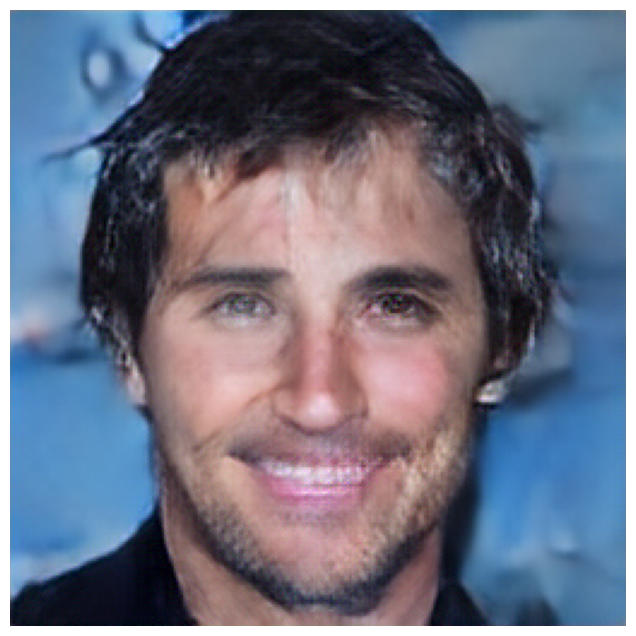

In [44]:
def infer_ddpm(prompt):
  # Create the noise scheduler
  scheduler = LinearNoiseScheduler(num_timesteps=diffusion_params["num_timesteps"],
                                   beta_start=diffusion_params["beta_start"],
                                   beta_end=diffusion_params["beta_end"])

  condition_config = get_config_value(ldm_params, key="condition_config", default_value=None)

  assert condition_config is not None, ("This sampling script is for image and text conditional but no conditioning config found")
  condition_types = get_config_value(condition_config, "condition_types", [])

  assert "text" in condition_types, ("This sampling script is for image and text conditional but no text condition found in config")
  assert "image" in condition_types, ("This sampling script is for image and text conditional but no image condition found in config")

  # Load tokenizer and text model
  with torch.inference_mode():
    # Also get empty text representation
    text_tokenizer, text_model = get_tokenizer_and_model(condition_config["text_condition_config"]["text_embed_model"], device=device)

  model = UNet(image_channels=autoencoder_params["z_channels"],
                model_config=ldm_params).to(device)

  ldm_checkpoint_path = os.path.join(train_params["task_name"], train_params["ldm_ckpt_name"])
  if os.path.exists(ldm_checkpoint_path):
    print("Loaded UNet Checkpoint")

    checkpoint = torch.load(ldm_checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint["model_state_dict"])
    print(checkpoint["epoch"])

  model.eval()

  # Create output directories
  if not os.path.exists(train_params["task_name"]):
    os.mkdir(train_params["task_name"])

  vae = VQVAE(image_channels=dataset_params["image_channels"], model_config=autoencoder_params).to(device)

  vae_checkpoint_path = os.path.join(train_params["task_name"], train_params["vqvae_autoencoder_ckpt_name"])
  if os.path.exists(vae_checkpoint_path):
    print("Loaded VQ-VAE checkpoint")

    checkpoint = torch.load(vae_checkpoint_path, map_location=device)
    vae.load_state_dict(checkpoint["model_state_dict"])

  vae.eval()

  with torch.inference_mode():
    sample_ddpm(model=model,
                scheduler=scheduler,
                vae=vae,
                text_tokenizer=text_tokenizer,
                text_model=text_model,
                prompt=prompt)

infer_ddpm(prompt="An attractive young man.")

In [46]:
!zip -r diffusion_samples.zip celebhq/samples

  adding: celebhq/samples/ (stored 0%)
  adding: celebhq/samples/x0_332.png (stored 0%)
  adding: celebhq/samples/x0_182.png (stored 0%)
  adding: celebhq/samples/x0_184.png (stored 0%)
  adding: celebhq/samples/x0_154.png (stored 0%)
  adding: celebhq/samples/x0_438.png (stored 0%)
  adding: celebhq/samples/x0_793.png (stored 0%)
  adding: celebhq/samples/x0_655.png (stored 0%)
  adding: celebhq/samples/x0_514.png (stored 0%)
  adding: celebhq/samples/x0_457.png (stored 0%)
  adding: celebhq/samples/x0_947.png (stored 0%)
  adding: celebhq/samples/x0_753.png (stored 0%)
  adding: celebhq/samples/x0_944.png (stored 0%)
  adding: celebhq/samples/x0_656.png (stored 0%)
  adding: celebhq/samples/x0_741.png (stored 0%)
  adding: celebhq/samples/x0_403.png (stored 0%)
  adding: celebhq/samples/x0_901.png (stored 0%)
  adding: celebhq/samples/x0_929.png (stored 0%)
  adding: celebhq/samples/x0_580.png (deflated 0%)
  adding: celebhq/samples/x0_200.png (deflated 0%)
  adding: celebhq/samples/

In [47]:
from google.colab import files
files.download("diffusion_samples.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [45]:
from google.colab import files
files.download("celebhq/ddpm_ckpt_class_cond.pth")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>